<a href="https://colab.research.google.com/github/scarlettyu2023/AI_agent_workshop/blob/main/Topic_1_Running_an_LLM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install huggingface_hub

In [ ]:
!hf version

huggingface_hub version: 0.36.0


In [ ]:
!git config --global credential.helper store
!hf auth login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
The token `scarlettyucs6501` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cac

In [ ]:
!hf auth whoami


user:  Scarlettyu


In [ ]:
from transformers import AutoModelForCausalLM

# No token argument needed - automatically uses saved token
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

# Verify that your setup is working by running llama_mmlu_eval.py which runs the model on two MMLU topics.  

In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = None  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\nâš ï¸  Evaluation interrupted by user")
    except Exception as e:
        print(f"\nâŒ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âœ“ GPU Available: Tesla T4
âœ“ GPU Memory: 15.83 GB
âœ“ Quantization disabled - loading full precision model
âœ“ Hugging Face authenticated

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: None (full precision)
Expected memory: ~2.5 GB (FP16)
Number of subjects: 2


Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

âœ“ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

âœ“ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.47 GB allocated, 2.51 GB reserved

Starting evaluation on 2 subjects


Progress: 1/2 subjects

Evaluating subject: astronomy


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

astronomy/test-00000-of-00001.parquet:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

astronomy/validation-00000-of-00001.parq(…):   0%|          | 0.00/6.05k [00:00<?, ?B/s]

astronomy/dev-00000-of-00001.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/152 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


âœ“ Result: 75/152 correct = 49.34%

Progress: 2/2 subjects

Evaluating subject: business_ethics


business_ethics/test-00000-of-00001.parq(…):   0%|          | 0.00/21.6k [00:00<?, ?B/s]

business_ethics/validation-00000-of-0000(…):   0%|          | 0.00/5.09k [00:00<?, ?B/s]

business_ethics/dev-00000-of-00001.parqu(…):   0%|          | 0.00/4.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 45/100 correct = 45.00%

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
None (full precision)
Total Subjects: 2
Total Questions: 252
Total Correct: 120
Overall Accuracy: 47.62%
Duration: 0.4 minutes

âœ“ Results saved to: llama_3.2_1b_mmlu_results_full_20260124_193724.json

ðŸ“Š Top 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

ðŸ“‰ Bottom 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260124_193724.json')

âœ… Evaluation complete!


#Time the code using the time shell command line function. Compare the timings for the following setups:



## 1.Using GPU and no quantization.

In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = None  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\nâš ï¸  Evaluation interrupted by user")
    except Exception as e:
        print(f"\nâŒ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âœ“ GPU Available: Tesla T4
âœ“ GPU Memory: 15.83 GB
âœ“ Quantization disabled - loading full precision model
âœ“ Hugging Face authenticated

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: None (full precision)
Expected memory: ~2.5 GB (FP16)
Number of subjects: 2


Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda
âœ“ Tokenizer loaded
Loading model (this may take 2-3 minutes)...
âœ“ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.48 GB allocated, 2.52 GB reserved

Starting evaluation on 2 subjects


Progress: 1/2 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

âœ“ Result: 75/152 correct = 49.34%

Progress: 2/2 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 45/100 correct = 45.00%

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
None (full precision)
Total Subjects: 2
Total Questions: 252
Total Correct: 120
Overall Accuracy: 47.62%
Duration: 0.2 minutes

âœ“ Results saved to: llama_3.2_1b_mmlu_results_full_20260124_193818.json

ðŸ“Š Top 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

ðŸ“‰ Bottom 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260124_193818.json')

âœ… Evaluation complete!


## 2.Using GPU and 4-bit quantization. (Not possible on a MacBook, skip if that is your laptop.)




In [ ]:
# First, ensure your Colab environment is set to a GPU runtime (Runtime -> Change runtime type).
# Then, uninstall existing bitsandbytes and torch
!pip uninstall -y bitsandbytes torch
# Reinstall torch and bitsandbytes compatible with Colab's typical CUDA 12.6
!pip install torch==2.9.0 --index-url https://download.pytorch.org/whl/cu126
!pip install bitsandbytes

print("\n--- IMPORTANT ---")
print("bitsandbytes and torch reinstalled. Please RESTART YOUR COLAB RUNTIME now (Runtime -> Restart runtime...).\nThen, re-run the 'Using GPU and 4-bit quantization' section.")

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.9/832.9 MB ? eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 5.6 MB/s eta 0:00:00

--- IMPORTANT ---
bitsandbytes and torch reinstalled. Please RESTART YOUR COLAB RUNTIME now (Runtime -> Restart runtime...).
Then, re-run the 'Using GPU and 4-bit quantization' section.


In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = 4  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    torch_dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\nâš ï¸  Evaluation interrupted by user")
    except Exception as e:
        print(f"\nâŒ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âœ“ GPU Available: Tesla T4
âœ“ GPU Memory: 15.83 GB
âœ“ bitsandbytes installed - 4-bit quantization available


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


âœ“ Hugging Face authenticated

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: 4-bit
Expected memory: ~1.5 GB
Number of subjects: 2


Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda
âœ“ Tokenizer loaded
Using 4-bit quantization (NF4 + double quant)
Memory usage: ~1.5 GB
Loading model (this may take 2-3 minutes)...
âœ“ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 1.03 GB allocated, 1.27 GB reserved
  Quantization: 4-bit active

Starting evaluation on 2 subjects


Progress: 1/2 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


âœ“ Result: 72/152 correct = 47.37%

Progress: 2/2 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 40/100 correct = 40.00%

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 4-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 112
Overall Accuracy: 44.44%
Duration: 0.4 minutes

âœ“ Results saved to: llama_3.2_1b_mmlu_results_4bit_20260124_195135.json

ðŸ“Š Top 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

ðŸ“‰ Bottom 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_4bit_20260124_195135.json')

âœ… Evaluation complete!


## 3.Using GPU and 8-bit quantization. (Not possible on a MacBook, skip if that is your laptop.)



In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = 8  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    torch_dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\nâš ï¸  Evaluation interrupted by user")
    except Exception as e:
        print(f"\nâŒ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âœ“ GPU Available: Tesla T4
âœ“ GPU Memory: 15.83 GB
âœ“ bitsandbytes installed - 8-bit quantization available
âœ“ Hugging Face authenticated

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: 8-bit
Expected memory: ~2.5 GB
Number of subjects: 2


Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda
âœ“ Tokenizer loaded
Using 8-bit quantization
Memory usage: ~2.5 GB
Loading model (this may take 2-3 minutes)...
âœ“ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.01 GB allocated, 2.16 GB reserved
  Quantization: 8-bit active

Starting evaluation on 2 subjects


Progress: 1/2 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

âœ“ Result: 76/152 correct = 50.00%

Progress: 2/2 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 45/100 correct = 45.00%

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 8-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 121
Overall Accuracy: 48.02%
Duration: 0.6 minutes

âœ“ Results saved to: llama_3.2_1b_mmlu_results_8bit_20260124_200739.json

ðŸ“Š Top 5 Subjects:
  1. astronomy: 50.00%
  2. business_ethics: 45.00%

ðŸ“‰ Bottom 5 Subjects:
  1. astronomy: 50.00%
  2. business_ethics: 45.00%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_8bit_20260124_200739.json')

âœ… Evaluation complete!


## 4.Using CPU and no quantization.

In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

!pip install -U bitsandbytes
!pip install bitsandbytes

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = False  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = None  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\nâš ï¸  Evaluation interrupted by user")
    except Exception as e:
        print(f"\nâŒ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âš ï¸  No GPU detected - running on CPU
âœ“ Quantization disabled - loading full precision model
âœ“ Hugging Face authenticated

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cpu
Quantization: None (full precision)
Expected memory: ~5 GB (FP32)
Number of subjects: 2


Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cpu
âœ“ Tokenizer loaded
Loading model (this may take 2-3 minutes)...
âœ“ Model loaded successfully!
  Model device: cpu
  Model dtype: torch.float32
  GPU Memory: 0.01 GB allocated, 2.17 GB reserved

Starting evaluation on 2 subjects


Progress: 1/2 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

âœ“ Result: 75/152 correct = 49.34%

Progress: 2/2 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 45/100 correct = 45.00%

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
None (full precision)
Total Subjects: 2
Total Questions: 252
Total Correct: 120
Overall Accuracy: 47.62%
Duration: 10.6 minutes

âœ“ Results saved to: llama_3.2_1b_mmlu_results_full_20260124_201957.json

ðŸ“Š Top 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

ðŸ“‰ Bottom 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260124_201957.json')

âœ… Evaluation complete!


## 5.Using CPU and 4-bit quantization.

In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = False  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = 4  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"âŒ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"âœ“ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\nâœ“ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\nðŸ“Š Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\nðŸ“‰ Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("ðŸ’¾ To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\nâœ… Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\nâš ï¸  Evaluation interrupted by user")
    except Exception as e:
        print(f"\nâŒ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
âœ“ Running in Google Colab
âœ“ Platform: Linux (x86_64)
âš ï¸  No GPU detected - running on CPU
âœ“ bitsandbytes installed - 4-bit quantization available
âœ“ Hugging Face authenticated

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cpu
Quantization: 4-bit
Expected memory: ~1.5 GB
Number of subjects: 2


Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cpu
âœ“ Tokenizer loaded
Using 4-bit quantization (NF4 + double quant)
Memory usage: ~1.5 GB
Loading model (this may take 2-3 minutes)...
âœ“ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 1.04 GB allocated, 2.17 GB reserved
  Quantization: 4-bit active

Starting evaluation on 2 subjects


Progress: 1/2 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

âœ“ Result: 72/152 correct = 47.37%

Progress: 2/2 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

âœ“ Result: 40/100 correct = 40.00%

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 4-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 112
Overall Accuracy: 44.44%
Duration: 0.6 minutes

âœ“ Results saved to: llama_3.2_1b_mmlu_results_4bit_20260124_202243.json

ðŸ“Š Top 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

ðŸ“‰ Bottom 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

ðŸ’¾ To download results in Colab:
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_4bit_20260124_202243.json')

âœ… Evaluation complete!


# Modify the code to do the following:

Run on a selection of 10 subjects using 2 other tiny/small models in addtion to Llama 3.2-1B.  

Add timing information to the evaluation summary showing the cycles consumed by each model.  Include all of real time, CPU time, and GPU time.

Add an option to the program to make it print out each question, the answer the model gives, and whether the answer is right or wrong.

## run with allenai/OLMo-2-0425-1B and Qwen/Qwen2.5-0.5B


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform
import time
import argparse

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

# Run 3 models total (your chosen model + 2 other tiny/small models)
MODEL_NAMES = [
    "allenai/OLMo-2-0425-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# Notes:
# - Quantization requires bitsandbytes: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
QUANTIZATION_BITS = None  # Change to 4 or 8 to enable quantization (CUDA only)

# Run on a selection of 10 subjects
MMLU_SUBJECTS = [
    "astronomy",
    "business_ethics",
    "computer_security",
    "formal_logic",
    "high_school_mathematics",
    "high_school_physics",
    "machine_learning",
    "management",
    "moral_disputes",
    "world_religions",
]

# Print each question + model answer + right/wrong
VERBOSE = False  # Can be overridden by CLI: --verbose


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "=" * 70)
                print("ERROR: Metal and Quantization Conflict")
                print("=" * 70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("=" * 70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"


def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("=" * 70)
    print("Environment Check")
    print("=" * 70)

    # Check if in Colab
    try:
        import google.colab  # noqa: F401
        print("✓ Running in Google Colab")
        in_colab = True
    except Exception:
        print("✓ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"✓ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"✓ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✓ GPU Available: {gpu_name}")
        print(f"✓ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("✓ Apple Metal (MPS) Available")
        print("✓ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("⚠️  No GPU detected - running on CPU")

    # Check quantization support
    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes  # noqa: F401
            print(f"✓ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print("❌ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)

        if device == "mps":
            print("❌ Apple METAL is incompatible with quantization")
            print("✓ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None  # IMPORTANT: do not exit; just disable
    else:
        print("✓ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("✓ Hugging Face authenticated")
        else:
            print("⚠️  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except Exception:
        print("⚠️  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "=" * 70)
    print("Configuration")
    print("=" * 70)
    print(f"Models: {len(MODEL_NAMES)}")
    for mn in MODEL_NAMES:
        print(f"  - {mn}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print("Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print("Expected memory: ~2.5 GB")
    else:
        print("Quantization: None (full precision)")
        if device in ["cuda", "mps"]:
            print("Expected memory: ~2.5 GB (FP16)")
        else:
            print("Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")
    print(f"Verbose per-question printing: {VERBOSE}")

    print("=" * 70 + "\n")
    return in_colab, device


def get_quantization_config(device):
    """Create quantization config based on settings (CUDA only)"""
    if QUANTIZATION_BITS is None:
        return None

    if device != "cuda":
        # Quantization only works with CUDA; disable otherwise
        print("⚠️  Quantization requested but device is not CUDA. Disabling quantization.")
        return None

    if QUANTIZATION_BITS == 4:
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(model_name, device):
    """Load model with optional quantization"""
    print(f"\nLoading model {model_name}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("✓ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config(device)

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (CUDA only)
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True,
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True,
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True,
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True,
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("✓ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available() and device == "cuda":
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print("  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\n❌ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Model gated / license not accepted - open model page on HF and accept")
        print("3. bitsandbytes not installed (for quantization) - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization (CUDA) or smaller model / CPU")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0,
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True,
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'=' * 70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'=' * 70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"❌ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if VERBOSE:
            is_correct = (predicted_answer == correct_answer)
            print("\n" + "-" * 70)
            print(question)
            for i, c in enumerate(choices):
                print(f"{['A','B','C','D'][i]}. {c}")
            print(f"Model: {predicted_answer} | Correct: {correct_answer} | {'RIGHT' if is_correct else 'WRONG'}")

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"✓ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy,
    }


def main():
    """Main evaluation function"""
    print("\n" + "=" * 70)
    print("MMLU Evaluation (Multi-Model, Optional Quantization)")
    print("=" * 70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # For combined summary at the end
    all_model_summaries = []
    output_files = []

    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for model_name in MODEL_NAMES:
        print("\n" + "#" * 70)
        print(f"MODEL: {model_name}")
        print("#" * 70)

        # Load model
        model, tokenizer = load_model_and_tokenizer(model_name, device)

        # Timing start (per model)
        real_start = time.perf_counter()
        cpu_start = time.process_time()

        gpu_seconds = None
        gpu_start_event = None
        gpu_end_event = None
        if device == "cuda":
            torch.cuda.synchronize()
            gpu_start_event = torch.cuda.Event(enable_timing=True)
            gpu_end_event = torch.cuda.Event(enable_timing=True)
            gpu_start_event.record()

        # Evaluate
        results = []
        total_correct = 0
        total_questions = 0

        print(f"\n{'=' * 70}")
        print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
        print(f"{'=' * 70}\n")

        for i, subject in enumerate(MMLU_SUBJECTS, 1):
            print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
            result = evaluate_subject(model, tokenizer, subject)
            if result:
                results.append(result)
                total_correct += result["correct"]
                total_questions += result["total"]

        # Timing end (per model)
        real_seconds = time.perf_counter() - real_start
        cpu_seconds = time.process_time() - cpu_start

        if device == "cuda" and gpu_start_event is not None and gpu_end_event is not None:
            gpu_end_event.record()
            torch.cuda.synchronize()
            gpu_seconds = gpu_start_event.elapsed_time(gpu_end_event) / 1000.0  # ms -> s

        # Calculate overall accuracy
        overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

        # Print summary (per model)
        print("\n" + "=" * 70)
        print("EVALUATION SUMMARY (Per Model)")
        print("=" * 70)
        print(f"Model: {model_name}")
        if QUANTIZATION_BITS and device == "cuda":
            print(f"Quantization: {QUANTIZATION_BITS}-bit")
        else:
            print("Quantization: None (full precision / disabled)")
        print(f"Device: {device}")
        print(f"Total Subjects: {len(results)}")
        print(f"Total Questions: {total_questions}")
        print(f"Total Correct: {total_correct}")
        print(f"Overall Accuracy: {overall_accuracy:.2f}%")
        print("\nTiming:")
        print(f"  Real time (wall): {real_seconds:.3f} seconds")
        print(f"  CPU time:         {cpu_seconds:.3f} seconds")
        if gpu_seconds is not None:
            print(f"  GPU time (CUDA):  {gpu_seconds:.3f} seconds")
        else:
            print("  GPU time:         N/A (CUDA only)")
        print("=" * 70)

        # Save results (per model)
        quant_suffix = f"_{QUANTIZATION_BITS}bit" if (QUANTIZATION_BITS and device == "cuda") else "_full"
        safe_model_name = model_name.replace("/", "__")
        output_file = f"mmlu_results_{safe_model_name}{quant_suffix}_{run_timestamp}.json"

        output_data = {
            "model": model_name,
            "quantization_bits": QUANTIZATION_BITS if device == "cuda" else None,
            "timestamp": run_timestamp,
            "device": str(device),
            "overall_accuracy": overall_accuracy,
            "total_correct": total_correct,
            "total_questions": total_questions,
            "timing_seconds": {
                "real_wall": real_seconds,
                "cpu": cpu_seconds,
                "gpu_cuda": gpu_seconds,
            },
            "subject_results": results,
        }

        with open(output_file, "w") as f:
            json.dump(output_data, f, indent=2)

        print(f"\n✓ Results saved to: {output_file}")

        output_files.append(output_file)
        all_model_summaries.append({
            "model": model_name,
            "accuracy": overall_accuracy,
            "questions": total_questions,
            "real_s": real_seconds,
            "cpu_s": cpu_seconds,
            "gpu_s": gpu_seconds,
            "file": output_file,
        })

        # Free memory before next model
        del model
        del tokenizer
        if device == "cuda":
            torch.cuda.empty_cache()

    # Combined summary
    print("\n" + "=" * 70)
    print("COMBINED SUMMARY (All Models)")
    print("=" * 70)
    for s in all_model_summaries:
        gpu_str = "N/A" if s["gpu_s"] is None else f"{s['gpu_s']:.3f}s"
        print(f"- {s['model']}")
        print(f"    Accuracy: {s['accuracy']:.2f}%  (N={s['questions']})")
        print(f"    Time: real {s['real_s']:.3f}s | cpu {s['cpu_s']:.3f}s | gpu {gpu_str}")
        print(f"    File: {s['file']}")

    # Colab-specific instructions
    if in_colab and len(output_files) > 0:
        print("\n" + "=" * 70)
        print("💾 To download results in Colab:")
        print("=" * 70)
        print("from google.colab import files")
        for f in output_files:
            print(f"files.download('{f}')")

    print("\n✅ Evaluation complete!")
    return output_files


if __name__ == "__main__":
    # Minimal CLI: only adds a verbose switch (keeps your “edit constants” workflow)
    parser = argparse.ArgumentParser()
    parser.add_argument("--verbose", action="store_true", help="Print each question and whether model is right/wrong")
    # Fix: Pass an empty list to parse_args() to prevent it from trying to parse Colab's internal arguments.
    args = parser.parse_args([])

    if args.verbose:
        VERBOSE = True

    try:
        output_files = main()
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


MMLU Evaluation (Multi-Model, Optional Quantization)

Environment Check
✓ Running in Google Colab
✓ Platform: Linux (x86_64)
✓ GPU Available: Tesla T4
✓ GPU Memory: 15.83 GB
✓ Quantization disabled - loading full precision model
✓ Hugging Face authenticated

Configuration
Models: 3
  - allenai/OLMo-2-0425-1B
  - meta-llama/Llama-3.2-1B-Instruct
  - TinyLlama/TinyLlama-1.1B-Chat-v1.0
Device: cuda
Quantization: None (full precision)
Expected memory: ~2.5 GB (FP16)
Number of subjects: 10
Verbose per-question printing: False


######################################################################
MODEL: allenai/OLMo-2-0425-1B
######################################################################

Loading model allenai/OLMo-2-0425-1B...
Device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/956M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 3.48 GB allocated, 4.37 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 61/152 correct = 40.13%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 37/100 correct = 37.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


computer_security/test-00000-of-00001.pa(…):   0%|          | 0.00/19.1k [00:00<?, ?B/s]

computer_security/validation-00000-of-00(…):   0%|          | 0.00/6.67k [00:00<?, ?B/s]

computer_security/dev-00000-of-00001.par(…):   0%|          | 0.00/4.33k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 45/100 correct = 45.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


formal_logic/test-00000-of-00001.parquet:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

formal_logic/validation-00000-of-00001.p(…):   0%|          | 0.00/6.56k [00:00<?, ?B/s]

formal_logic/dev-00000-of-00001.parquet:   0%|          | 0.00/4.81k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 25/126 correct = 19.84%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


high_school_mathematics/test-00000-of-00(…):   0%|          | 0.00/33.7k [00:00<?, ?B/s]

high_school_mathematics/validation-00000(…):   0%|          | 0.00/6.99k [00:00<?, ?B/s]

high_school_mathematics/dev-00000-of-000(…):   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 73/270 correct = 27.04%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


high_school_physics/test-00000-of-00001.(…):   0%|          | 0.00/33.0k [00:00<?, ?B/s]

high_school_physics/validation-00000-of-(…):   0%|          | 0.00/7.96k [00:00<?, ?B/s]

high_school_physics/dev-00000-of-00001.p(…):   0%|          | 0.00/4.57k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/151 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 46/151 correct = 30.46%

Progress: 7/10 subjects

Evaluating subject: machine_learning


machine_learning/test-00000-of-00001.par(…):   0%|          | 0.00/19.7k [00:00<?, ?B/s]

machine_learning/validation-00000-of-000(…):   0%|          | 0.00/6.17k [00:00<?, ?B/s]

machine_learning/dev-00000-of-00001.parq(…):   0%|          | 0.00/5.25k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/112 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 24/112 correct = 21.43%

Progress: 8/10 subjects

Evaluating subject: management


management/test-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

management/validation-00000-of-00001.par(…):   0%|          | 0.00/4.50k [00:00<?, ?B/s]

management/dev-00000-of-00001.parquet:   0%|          | 0.00/3.61k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/103 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 32/103 correct = 31.07%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


moral_disputes/test-00000-of-00001.parqu(…):   0%|          | 0.00/60.9k [00:00<?, ?B/s]

moral_disputes/validation-00000-of-00001(…):   0%|          | 0.00/10.7k [00:00<?, ?B/s]

moral_disputes/dev-00000-of-00001.parque(…):   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/346 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/38 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 136/346 correct = 39.31%

Progress: 10/10 subjects

Evaluating subject: world_religions


world_religions/test-00000-of-00001.parq(…):   0%|          | 0.00/18.9k [00:00<?, ?B/s]

world_religions/validation-00000-of-0000(…):   0%|          | 0.00/4.94k [00:00<?, ?B/s]

world_religions/dev-00000-of-00001.parqu(…):   0%|          | 0.00/3.30k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/171 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 81/171 correct = 47.37%

EVALUATION SUMMARY (Per Model)
Model: allenai/OLMo-2-0425-1B
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 560
Overall Accuracy: 34.33%

Timing:
  Real time (wall): 97.103 seconds
  CPU time:         52.204 seconds
  GPU time (CUDA):  97.073 seconds

✓ Results saved to: mmlu_results_allenai__OLMo-2-0425-1B_full_20260124_205301.json

######################################################################
MODEL: meta-llama/Llama-3.2-1B-Instruct
######################################################################

Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda
✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...
✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.48 GB allocated, 2.51 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 75/152 correct = 49.34%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 45/100 correct = 45.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 58/100 correct = 58.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 41/126 correct = 32.54%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 76/270 correct = 28.15%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 35/151 correct = 23.18%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 34/112 correct = 30.36%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 65/103 correct = 63.11%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 162/346 correct = 46.82%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 112/171 correct = 65.50%

EVALUATION SUMMARY (Per Model)
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 703
Overall Accuracy: 43.10%

Timing:
  Real time (wall): 66.590 seconds
  CPU time:         52.037 seconds
  GPU time (CUDA):  66.591 seconds

✓ Results saved to: mmlu_results_meta-llama__Llama-3.2-1B-Instruct_full_20260124_205301.json

######################################################################
MODEL: TinyLlama/TinyLlama-1.1B-Chat-v1.0
######################################################################

Loading model TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.21 GB allocated, 2.37 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 33/152 correct = 21.71%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 22/100 correct = 22.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 31/100 correct = 31.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 33/126 correct = 26.19%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 66/270 correct = 24.44%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 39/151 correct = 25.83%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 28/112 correct = 25.00%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 27/103 correct = 26.21%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 88/346 correct = 25.43%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 46/171 correct = 26.90%

EVALUATION SUMMARY (Per Model)
Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 413
Overall Accuracy: 25.32%

Timing:
  Real time (wall): 84.543 seconds
  CPU time:         67.103 seconds
  GPU time (CUDA):  84.539 seconds

✓ Results saved to: mmlu_results_TinyLlama__TinyLlama-1.1B-Chat-v1.0_full_20260124_205301.json

COMBINED SUMMARY (All Models)
- allenai/OLMo-2-0425-1B
    Accuracy: 34.33%  (N=1631)
    Time: real 97.103s | cpu 52.204s | gpu 97.073s
    File: mmlu_results_allenai__OLMo-2-0425-1B_full_20260124_205301.json
- meta-llama/Llama-3.2-1B-Instruct
    Accuracy: 43.10%  (N=1631)
    Time: real 66.590s | cpu 52.037s | gpu 66.591s
    File: mmlu_results_meta-llama__Llama-3.2-1B-Instruct_full_20260124_205301.json
- TinyLlama/TinyLlama-1.1B-Chat-v1.0
    Accuracy: 25.32%  (N=1631)
    Time: real 84.543s | cpu 67.103s | gpu 84.539s
    Fil

# Run the code and create graphs of the results.  Can you see any patterns to the mistakes each model makes or do they appear random?  Do the all the models make mistakes on the same questions?  




MMLU Evaluation (Multi-Model, Optional Quantization) + In-Memory Analysis

Environment Check
✓ Running in Google Colab
✓ Platform: Linux (x86_64)
✓ GPU Available: Tesla T4
✓ GPU Memory: 15.83 GB
✓ Quantization disabled - loading full precision model
✓ Hugging Face authenticated

Configuration
Models: 3
  - allenai/OLMo-2-0425-1B
  - meta-llama/Llama-3.2-1B-Instruct
  - TinyLlama/TinyLlama-1.1B-Chat-v1.0
Device: cuda
Quantization: None (full precision)
Number of subjects: 10
Verbose per-question printing: False


######################################################################
MODEL: allenai/OLMo-2-0425-1B
######################################################################

Loading model allenai/OLMo-2-0425-1B...
Device: cuda
✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/956M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.97 GB allocated, 3.79 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

astronomy/test-00000-of-00001.parquet:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

astronomy/validation-00000-of-00001.parq(…):   0%|          | 0.00/6.05k [00:00<?, ?B/s]

astronomy/dev-00000-of-00001.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/152 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 61/152 correct = 40.13%

Progress: 2/10 subjects

Evaluating subject: business_ethics


business_ethics/test-00000-of-00001.parq(…):   0%|          | 0.00/21.6k [00:00<?, ?B/s]

business_ethics/validation-00000-of-0000(…):   0%|          | 0.00/5.09k [00:00<?, ?B/s]

business_ethics/dev-00000-of-00001.parqu(…):   0%|          | 0.00/4.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 37/100 correct = 37.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


computer_security/test-00000-of-00001.pa(…):   0%|          | 0.00/19.1k [00:00<?, ?B/s]

computer_security/validation-00000-of-00(…):   0%|          | 0.00/6.67k [00:00<?, ?B/s]

computer_security/dev-00000-of-00001.par(…):   0%|          | 0.00/4.33k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 45/100 correct = 45.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


formal_logic/test-00000-of-00001.parquet:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

formal_logic/validation-00000-of-00001.p(…):   0%|          | 0.00/6.56k [00:00<?, ?B/s]

formal_logic/dev-00000-of-00001.parquet:   0%|          | 0.00/4.81k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 25/126 correct = 19.84%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


high_school_mathematics/test-00000-of-00(…):   0%|          | 0.00/33.7k [00:00<?, ?B/s]

high_school_mathematics/validation-00000(…):   0%|          | 0.00/6.99k [00:00<?, ?B/s]

high_school_mathematics/dev-00000-of-000(…):   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 73/270 correct = 27.04%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


high_school_physics/test-00000-of-00001.(…):   0%|          | 0.00/33.0k [00:00<?, ?B/s]

high_school_physics/validation-00000-of-(…):   0%|          | 0.00/7.96k [00:00<?, ?B/s]

high_school_physics/dev-00000-of-00001.p(…):   0%|          | 0.00/4.57k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/151 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 46/151 correct = 30.46%

Progress: 7/10 subjects

Evaluating subject: machine_learning


machine_learning/test-00000-of-00001.par(…):   0%|          | 0.00/19.7k [00:00<?, ?B/s]

machine_learning/validation-00000-of-000(…):   0%|          | 0.00/6.17k [00:00<?, ?B/s]

machine_learning/dev-00000-of-00001.parq(…):   0%|          | 0.00/5.25k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/112 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 24/112 correct = 21.43%

Progress: 8/10 subjects

Evaluating subject: management


management/test-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

management/validation-00000-of-00001.par(…):   0%|          | 0.00/4.50k [00:00<?, ?B/s]

management/dev-00000-of-00001.parquet:   0%|          | 0.00/3.61k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/103 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 32/103 correct = 31.07%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


moral_disputes/test-00000-of-00001.parqu(…):   0%|          | 0.00/60.9k [00:00<?, ?B/s]

moral_disputes/validation-00000-of-00001(…):   0%|          | 0.00/10.7k [00:00<?, ?B/s]

moral_disputes/dev-00000-of-00001.parque(…):   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/346 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/38 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 136/346 correct = 39.31%

Progress: 10/10 subjects

Evaluating subject: world_religions


world_religions/test-00000-of-00001.parq(…):   0%|          | 0.00/18.9k [00:00<?, ?B/s]

world_religions/validation-00000-of-0000(…):   0%|          | 0.00/4.94k [00:00<?, ?B/s]

world_religions/dev-00000-of-00001.parqu(…):   0%|          | 0.00/3.30k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/171 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 81/171 correct = 47.37%

EVALUATION SUMMARY (Per Model)
Model: allenai/OLMo-2-0425-1B
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 560
Overall Accuracy: 34.33%

Timing:
  Real time (wall): 80.533 seconds
  CPU time:         53.324 seconds
  GPU time (CUDA):  80.516 seconds

✓ Results saved to: mmlu_results_allenai__OLMo-2-0425-1B_full_20260127_185446.json

######################################################################
MODEL: meta-llama/Llama-3.2-1B-Instruct
######################################################################

Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.48 GB allocated, 2.56 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ Result: 75/152 correct = 49.34%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 45/100 correct = 45.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 58/100 correct = 58.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 41/126 correct = 32.54%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 76/270 correct = 28.15%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 35/151 correct = 23.18%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 34/112 correct = 30.36%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 65/103 correct = 63.11%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 162/346 correct = 46.82%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 112/171 correct = 65.50%

EVALUATION SUMMARY (Per Model)
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 703
Overall Accuracy: 43.10%

Timing:
  Real time (wall): 63.293 seconds
  CPU time:         53.439 seconds
  GPU time (CUDA):  63.287 seconds

✓ Results saved to: mmlu_results_meta-llama__Llama-3.2-1B-Instruct_full_20260127_185446.json

######################################################################
MODEL: TinyLlama/TinyLlama-1.1B-Chat-v1.0
######################################################################

Loading model TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.21 GB allocated, 2.61 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 33/152 correct = 21.71%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 22/100 correct = 22.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 31/100 correct = 31.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 33/126 correct = 26.19%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 66/270 correct = 24.44%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 39/151 correct = 25.83%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 28/112 correct = 25.00%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 27/103 correct = 26.21%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 88/346 correct = 25.43%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 46/171 correct = 26.90%

EVALUATION SUMMARY (Per Model)
Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 413
Overall Accuracy: 25.32%

Timing:
  Real time (wall): 75.183 seconds
  CPU time:         68.252 seconds
  GPU time (CUDA):  75.184 seconds

✓ Results saved to: mmlu_results_TinyLlama__TinyLlama-1.1B-Chat-v1.0_full_20260127_185446.json

COMBINED SUMMARY (All Models)
- allenai/OLMo-2-0425-1B
    Accuracy: 34.33%  (N=1631)
    Time: real 80.533s | cpu 53.324s | gpu 80.516s
- meta-llama/Llama-3.2-1B-Instruct
    Accuracy: 43.10%  (N=1631)
    Time: real 63.293s | cpu 53.439s | gpu 63.287s
- TinyLlama/TinyLlama-1.1B-Chat-v1.0
    Accuracy: 25.32%  (N=1631)
    Time: real 75.183s | cpu 68.252s | gpu 75.184s

=== Overall Summary ===


model  overall_accuracy_pct     real_s  \
1    meta-llama/Llama-3.2-1B-Instruct             43.102391  63.293251   
0              allenai/OLMo-2-0425-1B             34.334764  80.533011   
2  TinyLlama/TinyLlama-1.1B-Chat-v1.0             25.321888  75.182929   

       cpu_s      gpu_s  n_questions  
1  53.439287  63.287484         1631  
0  53.324499  80.516281         1631  
2  68.251770  75.183508         1631

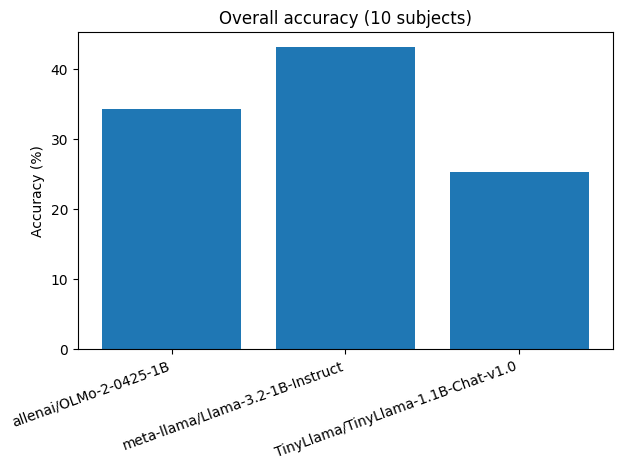

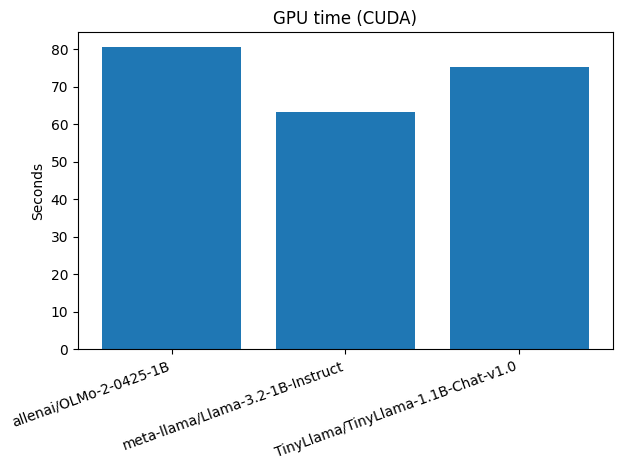


=== Per-subject Accuracy Table (%) ===


model                    TinyLlama/TinyLlama-1.1B-Chat-v1.0  \
subject                                                       
astronomy                                         21.710526   
business_ethics                                   22.000000   
computer_security                                 31.000000   
formal_logic                                      26.190476   
high_school_mathematics                           24.444444   
high_school_physics                               25.827815   
machine_learning                                  25.000000   
management                                        26.213592   
moral_disputes                                    25.433526   
world_religions                                   26.900585   

model                    allenai/OLMo-2-0425-1B  \
subject                                           
astronomy                             40.131579   
business_ethics                       37.000000   
computer_security                     45.000000   
formal_logic                          19.841270   
high_school_mathematics               27.037037   
high_school_physics                   30.463576   
machine_learning                      21.428571   
management                            31.067961   
moral_disputes                        39.306358   
world_religions                       47.368421   

model                    meta-llama/Llama-3.2-1B-Instruct  
subject                                                    
astronomy                                       49.342105  
business_ethics                                 45.000000  
computer_security                               58.000000  
formal_logic                                    32.539683  
high_school_mathematics                         28.148148  
high_school_physics                             23.178808  
machine_learning                                30.357143  
management                                      63.106796  
moral_disputes                                  46.820809  
world_religions                                 65.497076

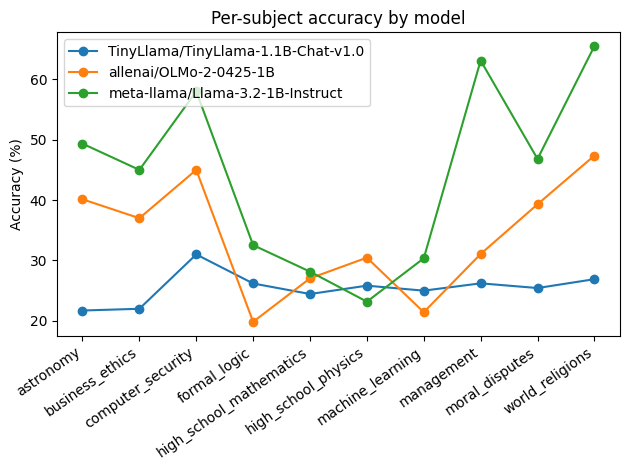


=== Questions missed by k models ===


num_wrong_models
0     87
1    387
2    641
3    516
Name: count, dtype: int64


=== Pairwise agreement (right/wrong) ===


pair  agree_rate  \
0  allenai/OLMo-2-0425-1B vs meta-llama/Llama-3.2...    0.624157   
1  allenai/OLMo-2-0425-1B vs TinyLlama/TinyLlama-...    0.581239   
2  meta-llama/Llama-3.2-1B-Instruct vs TinyLlama/...    0.534028   

   both_wrong_rate  both_right_rate  
0         0.424893         0.199264  
1         0.492336         0.088903  
2         0.424893         0.109135


Questions missed by ALL models: 516


qid    subject  index  \
0    astronomy::9  astronomy      9   
1   astronomy::10  astronomy     10   
2   astronomy::17  astronomy     17   
3   astronomy::21  astronomy     21   
4   astronomy::22  astronomy     22   
5   astronomy::25  astronomy     25   
6   astronomy::35  astronomy     35   
7   astronomy::39  astronomy     39   
8   astronomy::43  astronomy     43   
9   astronomy::44  astronomy     44   
10  astronomy::45  astronomy     45   
11  astronomy::47  astronomy     47   
12  astronomy::49  astronomy     49   
13  astronomy::53  astronomy     53   
14  astronomy::59  astronomy     59   
15  astronomy::63  astronomy     63   
16  astronomy::69  astronomy     69   
17  astronomy::77  astronomy     77   
18  astronomy::83  astronomy     83   
19  astronomy::84  astronomy     84   

                                             question  \
0   What is the source of the material that causes...   
1   Why does the plasma (ion) tail of a comet alwa...   
2                 Which of the following is not true?   
3     What is the Cassini division of Saturn's rings?   
4   Which of the following statements about sidere...   
5   The four big moons of Jupiter are Callisto Eur...   
6       What is not true of Jupiter's magnetic field?   
7   Jupiter and the other jovian planets are somet...   
8   Which of these has NOT been one of the main hy...   
9   We were first able to accurately measure the d...   
10  According to the Solar Nebular theory what are...   
11                      Life on Earth originated from   
12               How does the greenhouse effect work?   
13  Which of the following countries has sent land...   
14    When will the next major impact occur on Earth?   
15  Which of the following most likely explains wh...   
16  A sand bag has a mass of 5kg and weight 50N on...   
17  Our current best observations show that Pluto has   
18  How do scientists know that the majority of me...   
19  Which factor s most important in determining t...   

                                              choices  
0   [Near-Earth asteroids gradually disintegrate a...  
1   [Radiation pressure from the Sun's light pushe...  
2   [The Earth and Venus are in a 1:1 orbital reso...  
3   [a dark ring visible from Earth composed of da...  
4   [The time it takes for the Sun to make one cir...  
5                    [Callisto, Europa, Ganymede, Io]  
6   [it is about 20000 times stronger than Earth's...  
7   [The materials they are made of are not normal...  
8   [The Moon split from the Earth due to tidal fo...  
9   [a New Horizons flyby in the 1990s, Hubble Spa...  
10  [They are the shattered remains of collisions ...  
11  [We don't know for sure., aliens (panspermia)....  
12  [Ozone transmits visible light allowing it to ...  
13          [The U.S.S.R., The U.S., France, A and B]  
14  [Hundreds of millennia in the future., Major i...  
15  [Its rotation is too slow., It has too thick a...  
16  [Mass 5kg weight 100N, Mass 5kg weight 50N, Ma...  
17  [one medium sized satellite and two small sate...  
18  [The spectra of some meteorites are similar to...  
19  [size of the planet, presence of an atmosphere...


=== Subject-level overlap stats ===


subject  total  avg_wrong_models  frac_all_wrong  \
6         machine_learning    112          2.232143        0.446429   
4  high_school_mathematics    270          2.203704        0.400000   
5      high_school_physics    151          2.205298        0.390728   
3             formal_logic    126          2.214286        0.388889   
1          business_ethics    100          1.960000        0.350000   
8           moral_disputes    346          1.884393        0.297688   
7               management    103          1.796117        0.252427   
0                astronomy    152          1.888158        0.243421   
2        computer_security    100          1.660000        0.220000   
9          world_religions    171          1.602339        0.157895   

   frac_any_wrong  
6        0.973214  
4        0.981481  
5        0.960265  
3        0.984127  
1        0.890000  
8        0.947977  
7        0.893204  
0        0.953947  
2        0.910000  
9        0.912281


=== Prediction letter distribution (A/B/C/D) ===


model pred  count        pct
0   TinyLlama/TinyLlama-1.1B-Chat-v1.0    A     49   3.004292
1   TinyLlama/TinyLlama-1.1B-Chat-v1.0    B   1027  62.967505
2   TinyLlama/TinyLlama-1.1B-Chat-v1.0    C    305  18.700184
3   TinyLlama/TinyLlama-1.1B-Chat-v1.0    D    250  15.328020
4               allenai/OLMo-2-0425-1B    A    196  12.017167
5               allenai/OLMo-2-0425-1B    B    340  20.846107
6               allenai/OLMo-2-0425-1B    C    980  60.085837
7               allenai/OLMo-2-0425-1B    D    115   7.050889
8     meta-llama/Llama-3.2-1B-Instruct    A    479  29.368486
9     meta-llama/Llama-3.2-1B-Instruct    B    539  33.047210
10    meta-llama/Llama-3.2-1B-Instruct    C    297  18.209687
11    meta-llama/Llama-3.2-1B-Instruct    D    316  19.374617


NOTE:
- If many questions have num_wrong_models == 3, errors are NOT random; there's a shared hard set.
- Pairwise both_wrong_rate highlights shared failure modes between model pairs.
- If a model shows strong A-bias, it may be from the fallback-to-'A' logic in get_model_prediction().

💾 To download results in Colab (optional):
from google.colab import files
files.download('mmlu_results_allenai__OLMo-2-0425-1B_full_20260127_185446.json')
files.download('mmlu_results_meta-llama__Llama-3.2-1B-Instruct_full_20260127_185446.json')
files.download('mmlu_results_TinyLlama__TinyLlama-1.1B-Chat-v1.0_full_20260127_185446.json')

✅ Evaluation complete!


In [ ]:
# -*- coding: utf-8 -*-
"""
MMLU Evaluation Script (Multi-Model, Optional Quantization) — In-Memory Analysis + Plots

What this script does (minimal disruption to your structure):
1) Evaluates 3 tiny/small models on 10 MMLU subjects.
2) Records timing per model: real time, CPU time, GPU time (CUDA only).
3) Optional per-question printing (VERBOSE / --verbose).
4) Stores *per-question* predictions in memory (and also in output_data dict).
5) After evaluation, runs analysis directly from in-memory variables:
   - Overall + per-subject plots
   - Error overlap: how many questions missed by k models
   - Pairwise agreement
   - Shared hard questions (missed by all models)
   - Choice-letter bias plots

Notes:
- This is intended for Colab; parse_args([]) avoids colab internal args issues.
- Keeps your answer extraction logic; WARNING: fallback-to-"A" can induce A-bias.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform
import time
import argparse

# Analysis / plotting
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAMES = [
    "allenai/OLMo-2-0425-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

USE_GPU = True
MAX_NEW_TOKENS = 1

# Quantization (CUDA only)
QUANTIZATION_BITS = None  # 4, 8, or None

MMLU_SUBJECTS = [
    "astronomy",
    "business_ethics",
    "computer_security",
    "formal_logic",
    "high_school_mathematics",
    "high_school_physics",
    "machine_learning",
    "management",
    "moral_disputes",
    "world_religions",
]

VERBOSE = False  # overridden by CLI --verbose


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""
    if not USE_GPU:
        return "cpu"
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"
        if is_apple_arm:
            if QUANTIZATION_BITS is not None:
                print("\n" + "=" * 70)
                print("ERROR: Metal and Quantization Conflict")
                print("=" * 70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("=" * 70 + "\n")
                sys.exit(1)
            return "mps"
    return "cpu"


def check_environment():
    """Check environment and dependencies"""
    global QUANTIZATION_BITS

    print("=" * 70)
    print("Environment Check")
    print("=" * 70)

    # Colab check
    try:
        import google.colab  # noqa: F401
        print("✓ Running in Google Colab")
        in_colab = True
    except Exception:
        print("✓ Running locally (not in Colab)")
        in_colab = False

    print(f"✓ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"✓ Processor: {platform.processor()}")

    device = detect_device()

    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✓ GPU Available: {gpu_name}")
        print(f"✓ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("✓ Apple Metal (MPS) Available")
        print("✓ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("⚠️  No GPU detected - running on CPU")

    # Quantization support
    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes  # noqa: F401
            print(f"✓ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print("❌ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)

        if device == "mps":
            print("❌ Apple METAL is incompatible with quantization")
            print("✓ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
    else:
        print("✓ Quantization disabled - loading full precision model")

    # HF auth check
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("✓ Hugging Face authenticated")
        else:
            print("⚠️  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except Exception:
        print("⚠️  Could not check Hugging Face authentication")

    print("\n" + "=" * 70)
    print("Configuration")
    print("=" * 70)
    print(f"Models: {len(MODEL_NAMES)}")
    for mn in MODEL_NAMES:
        print(f"  - {mn}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        print("Note: quantization will be used only if device == cuda")
    else:
        print("Quantization: None (full precision)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")
    print(f"Verbose per-question printing: {VERBOSE}")
    print("=" * 70 + "\n")

    return in_colab, device


def get_quantization_config(device):
    """Create quantization config based on settings (CUDA only)"""
    if QUANTIZATION_BITS is None:
        return None

    if device != "cuda":
        print("⚠️  Quantization requested but device is not CUDA. Disabling quantization.")
        return None

    if QUANTIZATION_BITS == 4:
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(model_name, device):
    """Load model with optional quantization"""
    print(f"\nLoading model {model_name}...")
    print(f"Device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("✓ Tokenizer loaded")

    quant_config = get_quantization_config(device)

    print("Loading model (this may take 2-3 minutes)...")

    if quant_config is not None:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=quant_config,
            device_map="auto",
            low_cpu_mem_usage=True,
        )
    else:
        if device == "cuda":
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.float16,
                device_map="auto",
                low_cpu_mem_usage=True,
            )
        elif device == "mps":
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.float16,
                low_cpu_mem_usage=True,
            )
            model = model.to(device)
        else:
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.float32,
                low_cpu_mem_usage=True,
            )
            model = model.to(device)

    model.eval()

    print("✓ Model loaded successfully!")
    print(f"  Model device: {next(model.parameters()).device}")
    print(f"  Model dtype: {next(model.parameters()).dtype}")

    if torch.cuda.is_available() and device == "cuda":
        memory_allocated = torch.cuda.memory_allocated(0) / 1e9
        memory_reserved = torch.cuda.memory_reserved(0) / 1e9
        print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")
        if quant_config is not None:
            print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
    elif device == "mps":
        print("  Running on Apple Metal (MPS)")

    return model, tokenizer


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0,
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True,
    )

    answer = generated_text.strip()[:1].upper()

    # Try to recover if not A/B/C/D
    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            # WARNING: this fallback can create a strong "A" bias
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject. Returns per-question logs too."""
    print(f"\n{'=' * 70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'=' * 70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"❌ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0
    per_question = []

    for idx, example in enumerate(tqdm(dataset, desc=f"Testing {subject}", leave=True)):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)
        is_correct = (predicted_answer == correct_answer)

        per_question.append({
            "subject": subject,
            "index": idx,
            "question": question,
            "choices": choices,
            "correct": correct_answer,
            "pred": predicted_answer,
            "is_correct": is_correct,
        })

        if VERBOSE:
            print("\n" + "-" * 70)
            print(question)
            for i, c in enumerate(choices):
                print(f"{['A','B','C','D'][i]}. {c}")
            print(f"Model: {predicted_answer} | Correct: {correct_answer} | {'RIGHT' if is_correct else 'WRONG'}")

        if is_correct:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"✓ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy,
        "per_question": per_question,
    }


def analyze_and_plot(all_runs):
    """In-memory analysis and plots. Uses matplotlib only (no seaborn)."""
    # --- per model summary table ---
    overall = pd.DataFrame([{
        "model": r["model"],
        "overall_accuracy_pct": r["overall_accuracy"],
        "real_s": r["timing_seconds"]["real"],
        "cpu_s": r["timing_seconds"]["cpu"],
        "gpu_s": r["timing_seconds"]["gpu"],
        "n_questions": r["total_questions"],
    } for r in all_runs])

    print("\n=== Overall Summary ===")
    display(overall.sort_values("overall_accuracy_pct", ascending=False))

    plt.figure()
    plt.bar(overall["model"], overall["overall_accuracy_pct"])
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title("Overall accuracy (10 subjects)")
    plt.tight_layout()
    plt.show()

    # timing plots
    for col, title in [("real_s", "Real (wall) time"), ("cpu_s", "CPU time"), ("gpu_s", "GPU time (CUDA)")]:
        if overall[col].notna().any():
            plt.figure()
            plt.bar(overall["model"], overall[col])
            plt.xticks(rotation=20, ha="right")
            plt.ylabel("Seconds")
            plt.title(title)
            plt.tight_layout()
            plt.show()

    # --- per subject accuracy ---
    rows = []
    for run in all_runs:
        model = run["model"]
        for s in run["subject_results"]:
            rows.append({
                "model": model,
                "subject": s["subject"],
                "accuracy_pct": s["accuracy"],
                "correct": s["correct"],
                "total": s["total"],
            })
    df_subj = pd.DataFrame(rows)
    pivot = df_subj.pivot_table(index="subject", columns="model", values="accuracy_pct")

    print("\n=== Per-subject Accuracy Table (%) ===")
    display(pivot)

    plt.figure()
    for m in pivot.columns:
        plt.plot(pivot.index, pivot[m], marker="o", label=m)
    plt.xticks(rotation=35, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title("Per-subject accuracy by model")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- question-level overlap ---
    qrows = []
    for run in all_runs:
        model = run["model"]
        for s in run["subject_results"]:
            for q in s["per_question"]:
                qid = f"{q['subject']}::{q['index']}"
                qrows.append({
                    "qid": qid,
                    "subject": q["subject"],
                    "index": q["index"],
                    "model": model,
                    "pred": str(q["pred"]).upper()[:1],
                    "correct": str(q["correct"]).upper()[:1],
                    "is_correct": bool(q["is_correct"]),
                    "question": q["question"],
                    "choices": q["choices"],
                })
    df_q = pd.DataFrame(qrows)
    models = df_q["model"].unique().tolist()

    wide = df_q.pivot_table(index=["qid","subject","index"], columns="model", values="is_correct", aggfunc="first").reset_index()
    wrong_mat = ~wide[models]
    wide["num_wrong_models"] = wrong_mat.sum(axis=1)

    overlap = wide["num_wrong_models"].value_counts().sort_index()
    print("\n=== Questions missed by k models ===")
    display(overlap)

    plt.figure()
    plt.bar(overlap.index.astype(str), overlap.values)
    plt.xlabel("# models wrong on a question")
    plt.ylabel("# questions")
    plt.title("Error overlap across models")
    plt.tight_layout()
    plt.show()

    # pairwise agreement
    pair_rows = []
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            a, b = models[i], models[j]
            agree = (wide[a] == wide[b]).mean()
            both_wrong = ((~wide[a]) & (~wide[b])).mean()
            both_right = ((wide[a]) & (wide[b])).mean()
            pair_rows.append({
                "pair": f"{a} vs {b}",
                "agree_rate": agree,
                "both_wrong_rate": both_wrong,
                "both_right_rate": both_right,
            })
    pair_df = pd.DataFrame(pair_rows)
    print("\n=== Pairwise agreement (right/wrong) ===")
    display(pair_df)

    # all-model misses: show some items
    all_miss = wide[wide["num_wrong_models"] == len(models)][["qid","subject","index"]]
    print(f"\nQuestions missed by ALL models: {len(all_miss)}")
    if len(all_miss) > 0:
        shared = df_q.merge(all_miss, on=["qid","subject","index"], how="inner")
        shared_one = (shared.sort_values(["subject","index"])
                            .drop_duplicates(["qid"])
                            [["qid","subject","index","question","choices"]])
        display(shared_one.head(20))

    # subject-level: how "shared-hard" is each subject
    subj_group = wide.groupby("subject")["num_wrong_models"].agg(
        total="count",
        avg_wrong_models="mean",
        frac_all_wrong=lambda x: (x == len(models)).mean(),
        frac_any_wrong=lambda x: (x >= 1).mean(),
    ).reset_index()
    print("\n=== Subject-level overlap stats ===")
    display(subj_group.sort_values("frac_all_wrong", ascending=False))

    # choice bias per model
    pred_dist = (
        df_q.groupby(["model","pred"]).size().reset_index(name="count")
    )
    pred_dist["pct"] = pred_dist.groupby("model")["count"].transform(lambda s: s / s.sum() * 100)
    print("\n=== Prediction letter distribution (A/B/C/D) ===")
    display(pred_dist.sort_values(["model","pred"]))

    for m in models:
        tmp = pred_dist[pred_dist["model"] == m].set_index("pred").reindex(["A","B","C","D"]).fillna(0)
        plt.figure()
        plt.bar(tmp.index, tmp["pct"])
        plt.ylabel("% of predictions")
        plt.title(f"Answer-letter distribution: {m}")
        plt.tight_layout()
        plt.show()

    print("\nNOTE:")
    print("- If many questions have num_wrong_models == 3, errors are NOT random; there's a shared hard set.")
    print("- Pairwise both_wrong_rate highlights shared failure modes between model pairs.")
    print("- If a model shows strong A-bias, it may be from the fallback-to-'A' logic in get_model_prediction().")


def main():
    """Main evaluation function. Returns all_runs (in-memory)."""
    print("\n" + "=" * 70)
    print("MMLU Evaluation (Multi-Model, Optional Quantization) + In-Memory Analysis")
    print("=" * 70 + "\n")

    in_colab, device = check_environment()

    all_runs = []
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for model_name in MODEL_NAMES:
        print("\n" + "#" * 70)
        print(f"MODEL: {model_name}")
        print("#" * 70)

        model, tokenizer = load_model_and_tokenizer(model_name, device)

        # Timing start (per model)
        real_start = time.perf_counter()
        cpu_start = time.process_time()

        gpu_seconds = None
        gpu_start_event = None
        gpu_end_event = None
        if device == "cuda":
            torch.cuda.synchronize()
            gpu_start_event = torch.cuda.Event(enable_timing=True)
            gpu_end_event = torch.cuda.Event(enable_timing=True)
            gpu_start_event.record()

        # Evaluate
        results = []
        total_correct = 0
        total_questions = 0

        print(f"\n{'=' * 70}")
        print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
        print(f"{'=' * 70}\n")

        for i, subject in enumerate(MMLU_SUBJECTS, 1):
            print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
            result = evaluate_subject(model, tokenizer, subject)
            if result:
                results.append(result)
                total_correct += result["correct"]
                total_questions += result["total"]

        # Timing end (per model)
        real_seconds = time.perf_counter() - real_start
        cpu_seconds = time.process_time() - cpu_start

        if device == "cuda" and gpu_start_event is not None and gpu_end_event is not None:
            gpu_end_event.record()
            torch.cuda.synchronize()
            gpu_seconds = gpu_start_event.elapsed_time(gpu_end_event) / 1000.0  # ms -> s

        overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

        # Print summary (per model)
        print("\n" + "=" * 70)
        print("EVALUATION SUMMARY (Per Model)")
        print("=" * 70)
        print(f"Model: {model_name}")
        if QUANTIZATION_BITS and device == "cuda":
            print(f"Quantization: {QUANTIZATION_BITS}-bit")
        else:
            print("Quantization: None (full precision / disabled)")
        print(f"Device: {device}")
        print(f"Total Subjects: {len(results)}")
        print(f"Total Questions: {total_questions}")
        print(f"Total Correct: {total_correct}")
        print(f"Overall Accuracy: {overall_accuracy:.2f}%")
        print("\nTiming:")
        print(f"  Real time (wall): {real_seconds:.3f} seconds")
        print(f"  CPU time:         {cpu_seconds:.3f} seconds")
        if gpu_seconds is not None:
            print(f"  GPU time (CUDA):  {gpu_seconds:.3f} seconds")
        else:
            print("  GPU time:         N/A (CUDA only)")
        print("=" * 70)

        # Keep an output_data dict (still writes JSON like before; you can remove if unwanted)
        quant_suffix = f"_{QUANTIZATION_BITS}bit" if (QUANTIZATION_BITS and device == "cuda") else "_full"
        safe_model_name = model_name.replace("/", "__")
        output_file = f"mmlu_results_{safe_model_name}{quant_suffix}_{run_timestamp}.json"

        output_data = {
            "model": model_name,
            "quantization_bits": QUANTIZATION_BITS if device == "cuda" else None,
            "timestamp": run_timestamp,
            "device": str(device),
            "overall_accuracy": overall_accuracy,
            "total_correct": total_correct,
            "total_questions": total_questions,
            "timing_seconds": {"real": real_seconds, "cpu": cpu_seconds, "gpu": gpu_seconds},
            "subject_results": results,  # includes per_question
        }

        # Optional: still save (comment out if you truly don't want json)
        with open(output_file, "w") as f:
            json.dump(output_data, f, indent=2)
        print(f"\n✓ Results saved to: {output_file}")

        all_runs.append({
            "model": model_name,
            "device": device,
            "quantization_bits": QUANTIZATION_BITS if device == "cuda" else None,
            "overall_accuracy": overall_accuracy,
            "total_correct": total_correct,
            "total_questions": total_questions,
            "timing_seconds": {"real": real_seconds, "cpu": cpu_seconds, "gpu": gpu_seconds},
            "subject_results": results,
            "output_file": output_file,
        })

        # Free memory before next model
        del model
        del tokenizer
        if device == "cuda":
            torch.cuda.empty_cache()

    # Combined summary
    print("\n" + "=" * 70)
    print("COMBINED SUMMARY (All Models)")
    print("=" * 70)
    for r in all_runs:
        gpu_s = r["timing_seconds"]["gpu"]
        gpu_str = "N/A" if gpu_s is None else f"{gpu_s:.3f}s"
        print(f"- {r['model']}")
        print(f"    Accuracy: {r['overall_accuracy']:.2f}%  (N={r['total_questions']})")
        print(f"    Time: real {r['timing_seconds']['real']:.3f}s | cpu {r['timing_seconds']['cpu']:.3f}s | gpu {gpu_str}")

    # In-memory analysis + plots
    analyze_and_plot(all_runs)

    # Colab download hints
    if in_colab:
        print("\n" + "=" * 70)
        print("💾 To download results in Colab (optional):")
        print("=" * 70)
        print("from google.colab import files")
        for r in all_runs:
            print(f"files.download('{r['output_file']}')")

    print("\n✅ Evaluation complete!")
    return all_runs


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--verbose", action="store_true", help="Print each question and whether model is right/wrong")
    # Colab-safe:
    args = parser.parse_args([])

    if args.verbose:
        VERBOSE = True

    try:
        all_runs = main()
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


(1) Patterns vs random
The errors are clearly not random. Out of 1631 questions, only 87 (5.3%) are answered correctly by all three models, while 516 (31.6%) are missed by all three. In fact, 70.9% of the questions are missed by at least two models, indicating a large shared “hard set.” This structure is also subject-dependent: the fraction of questions missed by all models is highest in machine_learning (44.6%), high_school_mathematics (40.0%), high_school_physics (39.1%), and formal_logic (38.9%), which are more reasoning-intensive.

(2) Same questions wrong across models?
Yes. There is substantial overlap: 516/1631 (31.6%) of questions are missed by all three models. Pairwise overlaps are also large (both-wrong rates ~42–49%). Therefore, the models do not fail independently; they often fail on the same questions.

#In addition to running on the 3 small models from before, try ../3 medium-sized models.  Note that Google Colab has built in integration with Gemini as a coding assistant.


MMLU Evaluation (Multi-Model, Optional Quantization) + In-Memory Analysis

Environment Check
✓ Running in Google Colab
✓ Platform: Linux (x86_64)
✓ GPU Available: Tesla T4
✓ GPU Memory: 15.83 GB
✓ Quantization disabled - loading full precision model
✓ Hugging Face authenticated

Configuration
Models: 3
  - allenai/OLMo-2-0425-1B
  - meta-llama/Llama-3.2-1B-Instruct
  - TinyLlama/TinyLlama-1.1B-Chat-v1.0
Device: cuda
Quantization: None (full precision)
Number of subjects: 10
Verbose per-question printing: False


######################################################################
MODEL: allenai/OLMo-2-0425-1B
######################################################################

Loading model allenai/OLMo-2-0425-1B...
Device: cuda
✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.98 GB allocated, 3.79 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 61/152 correct = 40.13%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 37/100 correct = 37.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 45/100 correct = 45.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 25/126 correct = 19.84%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 73/270 correct = 27.04%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 46/151 correct = 30.46%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 24/112 correct = 21.43%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 32/103 correct = 31.07%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 136/346 correct = 39.31%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 81/171 correct = 47.37%

EVALUATION SUMMARY (Per Model)
Model: allenai/OLMo-2-0425-1B
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 560
Overall Accuracy: 34.33%

Timing:
  Real time (wall): 57.251 seconds
  CPU time:         51.390 seconds
  GPU time (CUDA):  57.252 seconds

✓ Results saved to: mmlu_results_allenai__OLMo-2-0425-1B_full_20260127_190429.json

######################################################################
MODEL: meta-llama/Llama-3.2-1B-Instruct
######################################################################

Loading model meta-llama/Llama-3.2-1B-Instruct...
Device: cuda
✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...
✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.48 GB allocated, 2.56 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 75/152 correct = 49.34%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 45/100 correct = 45.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 58/100 correct = 58.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 41/126 correct = 32.54%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 76/270 correct = 28.15%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 35/151 correct = 23.18%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 34/112 correct = 30.36%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 65/103 correct = 63.11%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 162/346 correct = 46.82%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 112/171 correct = 65.50%

EVALUATION SUMMARY (Per Model)
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 703
Overall Accuracy: 43.10%

Timing:
  Real time (wall): 59.122 seconds
  CPU time:         53.479 seconds
  GPU time (CUDA):  59.122 seconds

✓ Results saved to: mmlu_results_meta-llama__Llama-3.2-1B-Instruct_full_20260127_190429.json

######################################################################
MODEL: TinyLlama/TinyLlama-1.1B-Chat-v1.0
######################################################################

Loading model TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Device: cuda
✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...
✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 2.21 GB allocated, 2.61 GB reserved

Starting evaluation on 10 subjects


Progress: 1/10 subjects

Evaluating subject: astronomy


Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Result: 33/152 correct = 21.71%

Progress: 2/10 subjects

Evaluating subject: business_ethics


Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 22/100 correct = 22.00%

Progress: 3/10 subjects

Evaluating subject: computer_security


Testing computer_security:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Result: 31/100 correct = 31.00%

Progress: 4/10 subjects

Evaluating subject: formal_logic


Testing formal_logic:   0%|          | 0/126 [00:00<?, ?it/s]

✓ Result: 33/126 correct = 26.19%

Progress: 5/10 subjects

Evaluating subject: high_school_mathematics


Testing high_school_mathematics:   0%|          | 0/270 [00:00<?, ?it/s]

✓ Result: 66/270 correct = 24.44%

Progress: 6/10 subjects

Evaluating subject: high_school_physics


Testing high_school_physics:   0%|          | 0/151 [00:00<?, ?it/s]

✓ Result: 39/151 correct = 25.83%

Progress: 7/10 subjects

Evaluating subject: machine_learning


Testing machine_learning:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Result: 28/112 correct = 25.00%

Progress: 8/10 subjects

Evaluating subject: management


Testing management:   0%|          | 0/103 [00:00<?, ?it/s]

✓ Result: 27/103 correct = 26.21%

Progress: 9/10 subjects

Evaluating subject: moral_disputes


Testing moral_disputes:   0%|          | 0/346 [00:00<?, ?it/s]

✓ Result: 88/346 correct = 25.43%

Progress: 10/10 subjects

Evaluating subject: world_religions


Testing world_religions:   0%|          | 0/171 [00:00<?, ?it/s]

✓ Result: 46/171 correct = 26.90%

EVALUATION SUMMARY (Per Model)
Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Quantization: None (full precision / disabled)
Device: cuda
Total Subjects: 10
Total Questions: 1631
Total Correct: 413
Overall Accuracy: 25.32%

Timing:
  Real time (wall): 73.344 seconds
  CPU time:         67.024 seconds
  GPU time (CUDA):  73.345 seconds

✓ Results saved to: mmlu_results_TinyLlama__TinyLlama-1.1B-Chat-v1.0_full_20260127_190429.json

COMBINED SUMMARY (All Models)
- allenai/OLMo-2-0425-1B
    Accuracy: 34.33%  (N=1631)
    Time: real 57.251s | cpu 51.390s | gpu 57.252s
- meta-llama/Llama-3.2-1B-Instruct
    Accuracy: 43.10%  (N=1631)
    Time: real 59.122s | cpu 53.479s | gpu 59.122s
- TinyLlama/TinyLlama-1.1B-Chat-v1.0
    Accuracy: 25.32%  (N=1631)
    Time: real 73.344s | cpu 67.024s | gpu 73.345s

=== Overall Summary ===


model  overall_accuracy_pct     real_s  \
1    meta-llama/Llama-3.2-1B-Instruct             43.102391  59.121866   
0              allenai/OLMo-2-0425-1B             34.334764  57.251239   
2  TinyLlama/TinyLlama-1.1B-Chat-v1.0             25.321888  73.344415   

       cpu_s      gpu_s  n_questions  
1  53.478664  59.122301         1631  
0  51.390180  57.251570         1631  
2  67.024067  73.344930         1631

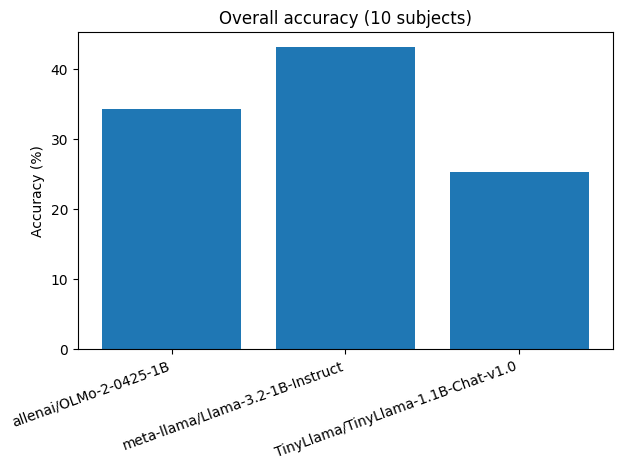

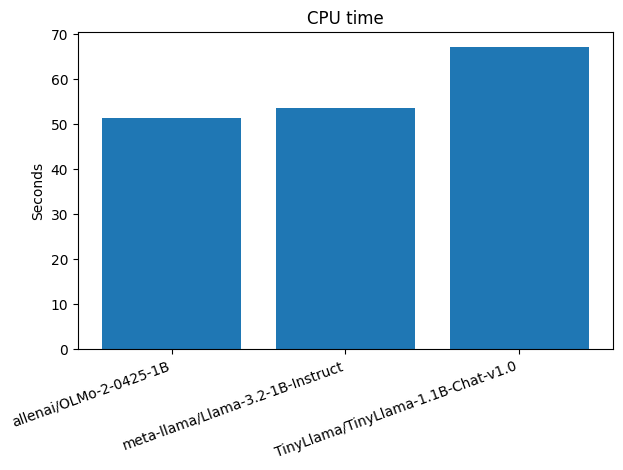


=== Per-subject Accuracy Table (%) ===


model                    TinyLlama/TinyLlama-1.1B-Chat-v1.0  \
subject                                                       
astronomy                                         21.710526   
business_ethics                                   22.000000   
computer_security                                 31.000000   
formal_logic                                      26.190476   
high_school_mathematics                           24.444444   
high_school_physics                               25.827815   
machine_learning                                  25.000000   
management                                        26.213592   
moral_disputes                                    25.433526   
world_religions                                   26.900585   

model                    allenai/OLMo-2-0425-1B  \
subject                                           
astronomy                             40.131579   
business_ethics                       37.000000   
computer_security                     45.000000   
formal_logic                          19.841270   
high_school_mathematics               27.037037   
high_school_physics                   30.463576   
machine_learning                      21.428571   
management                            31.067961   
moral_disputes                        39.306358   
world_religions                       47.368421   

model                    meta-llama/Llama-3.2-1B-Instruct  
subject                                                    
astronomy                                       49.342105  
business_ethics                                 45.000000  
computer_security                               58.000000  
formal_logic                                    32.539683  
high_school_mathematics                         28.148148  
high_school_physics                             23.178808  
machine_learning                                30.357143  
management                                      63.106796  
moral_disputes                                  46.820809  
world_religions                                 65.497076

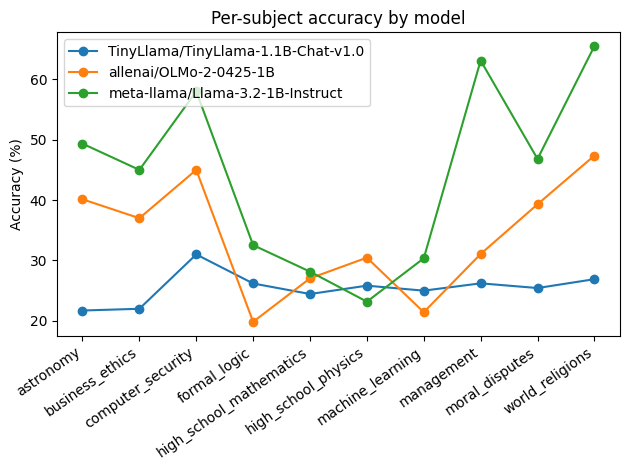


=== Questions missed by k models ===


num_wrong_models
0     87
1    387
2    641
3    516
Name: count, dtype: int64

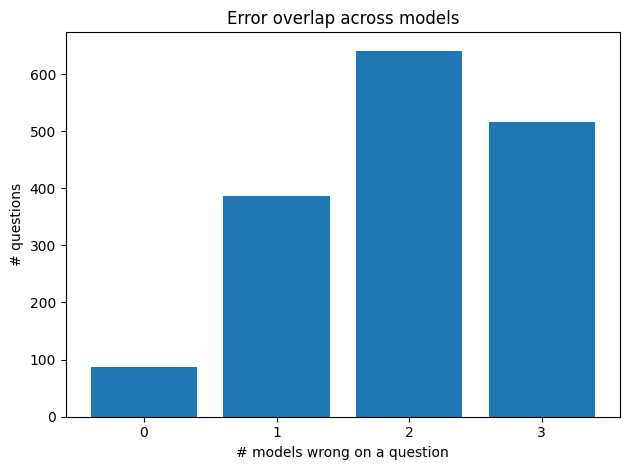


=== Pairwise agreement (right/wrong) ===


pair  agree_rate  \
0  allenai/OLMo-2-0425-1B vs meta-llama/Llama-3.2...    0.624157   
1  allenai/OLMo-2-0425-1B vs TinyLlama/TinyLlama-...    0.581239   
2  meta-llama/Llama-3.2-1B-Instruct vs TinyLlama/...    0.534028   

   both_wrong_rate  both_right_rate  
0         0.424893         0.199264  
1         0.492336         0.088903  
2         0.424893         0.109135


Questions missed by ALL models: 516


qid    subject  index  \
0    astronomy::9  astronomy      9   
1   astronomy::10  astronomy     10   
2   astronomy::17  astronomy     17   
3   astronomy::21  astronomy     21   
4   astronomy::22  astronomy     22   
5   astronomy::25  astronomy     25   
6   astronomy::35  astronomy     35   
7   astronomy::39  astronomy     39   
8   astronomy::43  astronomy     43   
9   astronomy::44  astronomy     44   
10  astronomy::45  astronomy     45   
11  astronomy::47  astronomy     47   
12  astronomy::49  astronomy     49   
13  astronomy::53  astronomy     53   
14  astronomy::59  astronomy     59   
15  astronomy::63  astronomy     63   
16  astronomy::69  astronomy     69   
17  astronomy::77  astronomy     77   
18  astronomy::83  astronomy     83   
19  astronomy::84  astronomy     84   

                                             question  \
0   What is the source of the material that causes...   
1   Why does the plasma (ion) tail of a comet alwa...   
2                 Which of the following is not true?   
3     What is the Cassini division of Saturn's rings?   
4   Which of the following statements about sidere...   
5   The four big moons of Jupiter are Callisto Eur...   
6       What is not true of Jupiter's magnetic field?   
7   Jupiter and the other jovian planets are somet...   
8   Which of these has NOT been one of the main hy...   
9   We were first able to accurately measure the d...   
10  According to the Solar Nebular theory what are...   
11                      Life on Earth originated from   
12               How does the greenhouse effect work?   
13  Which of the following countries has sent land...   
14    When will the next major impact occur on Earth?   
15  Which of the following most likely explains wh...   
16  A sand bag has a mass of 5kg and weight 50N on...   
17  Our current best observations show that Pluto has   
18  How do scientists know that the majority of me...   
19  Which factor s most important in determining t...   

                                              choices  
0   [Near-Earth asteroids gradually disintegrate a...  
1   [Radiation pressure from the Sun's light pushe...  
2   [The Earth and Venus are in a 1:1 orbital reso...  
3   [a dark ring visible from Earth composed of da...  
4   [The time it takes for the Sun to make one cir...  
5                    [Callisto, Europa, Ganymede, Io]  
6   [it is about 20000 times stronger than Earth's...  
7   [The materials they are made of are not normal...  
8   [The Moon split from the Earth due to tidal fo...  
9   [a New Horizons flyby in the 1990s, Hubble Spa...  
10  [They are the shattered remains of collisions ...  
11  [We don't know for sure., aliens (panspermia)....  
12  [Ozone transmits visible light allowing it to ...  
13          [The U.S.S.R., The U.S., France, A and B]  
14  [Hundreds of millennia in the future., Major i...  
15  [Its rotation is too slow., It has too thick a...  
16  [Mass 5kg weight 100N, Mass 5kg weight 50N, Ma...  
17  [one medium sized satellite and two small sate...  
18  [The spectra of some meteorites are similar to...  
19  [size of the planet, presence of an atmosphere...


=== Subject-level overlap stats ===


subject  total  avg_wrong_models  frac_all_wrong  \
6         machine_learning    112          2.232143        0.446429   
4  high_school_mathematics    270          2.203704        0.400000   
5      high_school_physics    151          2.205298        0.390728   
3             formal_logic    126          2.214286        0.388889   
1          business_ethics    100          1.960000        0.350000   
8           moral_disputes    346          1.884393        0.297688   
7               management    103          1.796117        0.252427   
0                astronomy    152          1.888158        0.243421   
2        computer_security    100          1.660000        0.220000   
9          world_religions    171          1.602339        0.157895   

   frac_any_wrong  
6        0.973214  
4        0.981481  
5        0.960265  
3        0.984127  
1        0.890000  
8        0.947977  
7        0.893204  
0        0.953947  
2        0.910000  
9        0.912281


=== Prediction letter distribution (A/B/C/D) ===


model pred  count        pct
0   TinyLlama/TinyLlama-1.1B-Chat-v1.0    A     49   3.004292
1   TinyLlama/TinyLlama-1.1B-Chat-v1.0    B   1027  62.967505
2   TinyLlama/TinyLlama-1.1B-Chat-v1.0    C    305  18.700184
3   TinyLlama/TinyLlama-1.1B-Chat-v1.0    D    250  15.328020
4               allenai/OLMo-2-0425-1B    A    196  12.017167
5               allenai/OLMo-2-0425-1B    B    340  20.846107
6               allenai/OLMo-2-0425-1B    C    980  60.085837
7               allenai/OLMo-2-0425-1B    D    115   7.050889
8     meta-llama/Llama-3.2-1B-Instruct    A    479  29.368486
9     meta-llama/Llama-3.2-1B-Instruct    B    539  33.047210
10    meta-llama/Llama-3.2-1B-Instruct    C    297  18.209687
11    meta-llama/Llama-3.2-1B-Instruct    D    316  19.374617

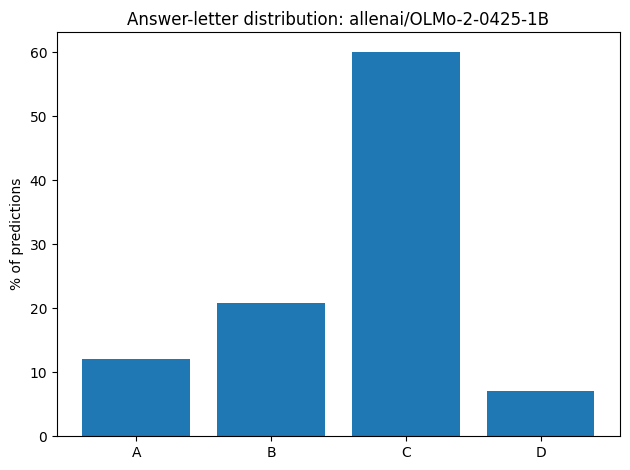

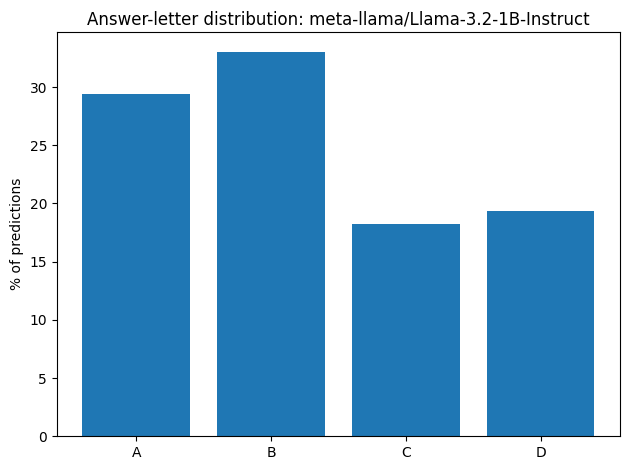

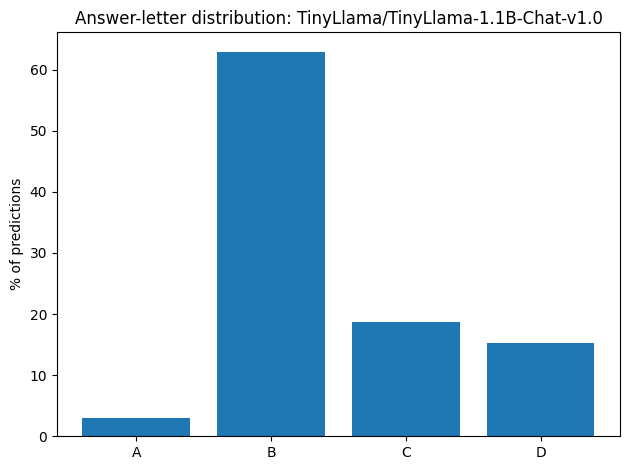


NOTE:
- If many questions have num_wrong_models == 3, errors are NOT random; there's a shared hard set.
- Pairwise both_wrong_rate highlights shared failure modes between model pairs.
- If a model shows strong A-bias, it may be from the fallback-to-'A' logic in get_model_prediction().

💾 To download results in Colab (optional):
from google.colab import files
files.download('mmlu_results_allenai__OLMo-2-0425-1B_full_20260127_190429.json')
files.download('mmlu_results_meta-llama__Llama-3.2-1B-Instruct_full_20260127_190429.json')
files.download('mmlu_results_TinyLlama__TinyLlama-1.1B-Chat-v1.0_full_20260127_190429.json')

✅ Evaluation complete!


In [ ]:
# -*- coding: utf-8 -*-
"""
MMLU Evaluation Script (Multi-Model, Optional Quantization) — In-Memory Analysis + Plots

What this script does (minimal disruption to your structure):
1) Evaluates 3 tiny/small models on 10 MMLU subjects.
2) Records timing per model: real time, CPU time, GPU time (CUDA only).
3) Optional per-question printing (VERBOSE / --verbose).
4) Stores *per-question* predictions in memory (and also in output_data dict).
5) After evaluation, runs analysis directly from in-memory variables:
   - Overall + per-subject plots
   - Error overlap: how many questions missed by k models
   - Pairwise agreement
   - Shared hard questions (missed by all models)
   - Choice-letter bias plots

Notes:
- This is intended for Colab; parse_args([]) avoids colab internal args issues.
- Keeps your answer extraction logic; WARNING: fallback-to-"A" can induce A-bias.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform
import time
import argparse

# Analysis / plotting
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAMES = [
    "allenai/OLMo-2-0425-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

USE_GPU = True
MAX_NEW_TOKENS = 1

# Quantization (CUDA only)
QUANTIZATION_BITS = None  # 4, 8, or None

MMLU_SUBJECTS = [
    "astronomy",
    "business_ethics",
    "computer_security",
    "formal_logic",
    "high_school_mathematics",
    "high_school_physics",
    "machine_learning",
    "management",
    "moral_disputes",
    "world_religions",
]

VERBOSE = False  # overridden by CLI --verbose


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""
    if not USE_GPU:
        return "cpu"
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"
        if is_apple_arm:
            if QUANTIZATION_BITS is not None:
                print("\n" + "=" * 70)
                print("ERROR: Metal and Quantization Conflict")
                print("=" * 70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("=" * 70 + "\n")
                sys.exit(1)
            return "mps"
    return "cpu"


def check_environment():
    """Check environment and dependencies"""
    global QUANTIZATION_BITS

    print("=" * 70)
    print("Environment Check")
    print("=" * 70)

    # Colab check
    try:
        import google.colab  # noqa: F401
        print("✓ Running in Google Colab")
        in_colab = True
    except Exception:
        print("✓ Running locally (not in Colab)")
        in_colab = False

    print(f"✓ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"✓ Processor: {platform.processor()}")

    device = detect_device()

    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✓ GPU Available: {gpu_name}")
        print(f"✓ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("✓ Apple Metal (MPS) Available")
        print("✓ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("⚠️  No GPU detected - running on CPU")

    # Quantization support
    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes  # noqa: F401
            print(f"✓ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print("❌ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)

        if device == "mps":
            print("❌ Apple METAL is incompatible with quantization")
            print("✓ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
    else:
        print("✓ Quantization disabled - loading full precision model")

    # HF auth check
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("✓ Hugging Face authenticated")
        else:
            print("⚠️  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except Exception:
        print("⚠️  Could not check Hugging Face authentication")

    print("\n" + "=" * 70)
    print("Configuration")
    print("=" * 70)
    print(f"Models: {len(MODEL_NAMES)}")
    for mn in MODEL_NAMES:
        print(f"  - {mn}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        print("Note: quantization will be used only if device == cuda")
    else:
        print("Quantization: None (full precision)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")
    print(f"Verbose per-question printing: {VERBOSE}")
    print("=" * 70 + "\n")

    return in_colab, device


def get_quantization_config(device):
    """Create quantization config based on settings (CUDA only)"""
    if QUANTIZATION_BITS is None:
        return None

    if device != "cuda":
        print("⚠️  Quantization requested but device is not CUDA. Disabling quantization.")
        return None

    if QUANTIZATION_BITS == 4:
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(model_name, device):
    """Load model with optional quantization"""
    print(f"\nLoading model {model_name}...")
    print(f"Device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("✓ Tokenizer loaded")

    quant_config = get_quantization_config(device)

    print("Loading model (this may take 2-3 minutes)...")

    if quant_config is not None:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=quant_config,
            device_map="auto",
            low_cpu_mem_usage=True,
        )
    else:
        if device == "cuda":
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.float16,
                device_map="auto",
                low_cpu_mem_usage=True,
            )
        elif device == "mps":
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.float16,
                low_cpu_mem_usage=True,
            )
            model = model.to(device)
        else:
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.float32,
                low_cpu_mem_usage=True,
            )
            model = model.to(device)

    model.eval()

    print("✓ Model loaded successfully!")
    print(f"  Model device: {next(model.parameters()).device}")
    print(f"  Model dtype: {next(model.parameters()).dtype}")

    if torch.cuda.is_available() and device == "cuda":
        memory_allocated = torch.cuda.memory_allocated(0) / 1e9
        memory_reserved = torch.cuda.memory_reserved(0) / 1e9
        print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")
        if quant_config is not None:
            print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
    elif device == "mps":
        print("  Running on Apple Metal (MPS)")

    return model, tokenizer


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0,
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True,
    )

    answer = generated_text.strip()[:1].upper()

    # Try to recover if not A/B/C/D
    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            # WARNING: this fallback can create a strong "A" bias
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject. Returns per-question logs too."""
    print(f"\n{'=' * 70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'=' * 70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"❌ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0
    per_question = []

    for idx, example in enumerate(tqdm(dataset, desc=f"Testing {subject}", leave=True)):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)
        is_correct = (predicted_answer == correct_answer)

        per_question.append({
            "subject": subject,
            "index": idx,
            "question": question,
            "choices": choices,
            "correct": correct_answer,
            "pred": predicted_answer,
            "is_correct": is_correct,
        })

        if VERBOSE:
            print("\n" + "-" * 70)
            print(question)
            for i, c in enumerate(choices):
                print(f"{['A','B','C','D'][i]}. {c}")
            print(f"Model: {predicted_answer} | Correct: {correct_answer} | {'RIGHT' if is_correct else 'WRONG'}")

        if is_correct:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"✓ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy,
        "per_question": per_question,
    }


def analyze_and_plot(all_runs):
    """In-memory analysis and plots. Uses matplotlib only (no seaborn)."""
    # --- per model summary table ---
    overall = pd.DataFrame([{
        "model": r["model"],
        "overall_accuracy_pct": r["overall_accuracy"],
        "real_s": r["timing_seconds"]["real"],
        "cpu_s": r["timing_seconds"]["cpu"],
        "gpu_s": r["timing_seconds"]["gpu"],
        "n_questions": r["total_questions"],
    } for r in all_runs])

    print("\n=== Overall Summary ===")
    display(overall.sort_values("overall_accuracy_pct", ascending=False))

    plt.figure()
    plt.bar(overall["model"], overall["overall_accuracy_pct"])
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title("Overall accuracy (10 subjects)")
    plt.tight_layout()
    plt.show()

    # timing plots
    for col, title in [("real_s", "Real (wall) time"), ("cpu_s", "CPU time"), ("gpu_s", "GPU time (CUDA)")]:
        if overall[col].notna().any():
            plt.figure()
            plt.bar(overall["model"], overall[col])
            plt.xticks(rotation=20, ha="right")
            plt.ylabel("Seconds")
            plt.title(title)
            plt.tight_layout()
            plt.show()

    # --- per subject accuracy ---
    rows = []
    for run in all_runs:
        model = run["model"]
        for s in run["subject_results"]:
            rows.append({
                "model": model,
                "subject": s["subject"],
                "accuracy_pct": s["accuracy"],
                "correct": s["correct"],
                "total": s["total"],
            })
    df_subj = pd.DataFrame(rows)
    pivot = df_subj.pivot_table(index="subject", columns="model", values="accuracy_pct")

    print("\n=== Per-subject Accuracy Table (%) ===")
    display(pivot)

    plt.figure()
    for m in pivot.columns:
        plt.plot(pivot.index, pivot[m], marker="o", label=m)
    plt.xticks(rotation=35, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title("Per-subject accuracy by model")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- question-level overlap ---
    qrows = []
    for run in all_runs:
        model = run["model"]
        for s in run["subject_results"]:
            for q in s["per_question"]:
                qid = f"{q['subject']}::{q['index']}"
                qrows.append({
                    "qid": qid,
                    "subject": q["subject"],
                    "index": q["index"],
                    "model": model,
                    "pred": str(q["pred"]).upper()[:1],
                    "correct": str(q["correct"]).upper()[:1],
                    "is_correct": bool(q["is_correct"]),
                    "question": q["question"],
                    "choices": q["choices"],
                })
    df_q = pd.DataFrame(qrows)
    models = df_q["model"].unique().tolist()

    wide = df_q.pivot_table(index=["qid","subject","index"], columns="model", values="is_correct", aggfunc="first").reset_index()
    wrong_mat = ~wide[models]
    wide["num_wrong_models"] = wrong_mat.sum(axis=1)

    overlap = wide["num_wrong_models"].value_counts().sort_index()
    print("\n=== Questions missed by k models ===")
    display(overlap)

    plt.figure()
    plt.bar(overlap.index.astype(str), overlap.values)
    plt.xlabel("# models wrong on a question")
    plt.ylabel("# questions")
    plt.title("Error overlap across models")
    plt.tight_layout()
    plt.show()

    # pairwise agreement
    pair_rows = []
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            a, b = models[i], models[j]
            agree = (wide[a] == wide[b]).mean()
            both_wrong = ((~wide[a]) & (~wide[b])).mean()
            both_right = ((wide[a]) & (wide[b])).mean()
            pair_rows.append({
                "pair": f"{a} vs {b}",
                "agree_rate": agree,
                "both_wrong_rate": both_wrong,
                "both_right_rate": both_right,
            })
    pair_df = pd.DataFrame(pair_rows)
    print("\n=== Pairwise agreement (right/wrong) ===")
    display(pair_df)

    # all-model misses: show some items
    all_miss = wide[wide["num_wrong_models"] == len(models)][["qid","subject","index"]]
    print(f"\nQuestions missed by ALL models: {len(all_miss)}")
    if len(all_miss) > 0:
        shared = df_q.merge(all_miss, on=["qid","subject","index"], how="inner")
        shared_one = (shared.sort_values(["subject","index"])
                            .drop_duplicates(["qid"])
                            [["qid","subject","index","question","choices"]])
        display(shared_one.head(20))

    # subject-level: how "shared-hard" is each subject
    subj_group = wide.groupby("subject")["num_wrong_models"].agg(
        total="count",
        avg_wrong_models="mean",
        frac_all_wrong=lambda x: (x == len(models)).mean(),
        frac_any_wrong=lambda x: (x >= 1).mean(),
    ).reset_index()
    print("\n=== Subject-level overlap stats ===")
    display(subj_group.sort_values("frac_all_wrong", ascending=False))

    # choice bias per model
    pred_dist = (
        df_q.groupby(["model","pred"]).size().reset_index(name="count")
    )
    pred_dist["pct"] = pred_dist.groupby("model")["count"].transform(lambda s: s / s.sum() * 100)
    print("\n=== Prediction letter distribution (A/B/C/D) ===")
    display(pred_dist.sort_values(["model","pred"]))

    for m in models:
        tmp = pred_dist[pred_dist["model"] == m].set_index("pred").reindex(["A","B","C","D"]).fillna(0)
        plt.figure()
        plt.bar(tmp.index, tmp["pct"])
        plt.ylabel("% of predictions")
        plt.title(f"Answer-letter distribution: {m}")
        plt.tight_layout()
        plt.show()

    print("\nNOTE:")
    print("- If many questions have num_wrong_models == 3, errors are NOT random; there's a shared hard set.")
    print("- Pairwise both_wrong_rate highlights shared failure modes between model pairs.")
    print("- If a model shows strong A-bias, it may be from the fallback-to-'A' logic in get_model_prediction().")


def main():
    """Main evaluation function. Returns all_runs (in-memory)."""
    print("\n" + "=" * 70)
    print("MMLU Evaluation (Multi-Model, Optional Quantization) + In-Memory Analysis")
    print("=" * 70 + "\n")

    in_colab, device = check_environment()

    all_runs = []
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for model_name in MODEL_NAMES:
        print("\n" + "#" * 70)
        print(f"MODEL: {model_name}")
        print("#" * 70)

        model, tokenizer = load_model_and_tokenizer(model_name, device)

        # Timing start (per model)
        real_start = time.perf_counter()
        cpu_start = time.process_time()

        gpu_seconds = None
        gpu_start_event = None
        gpu_end_event = None
        if device == "cuda":
            torch.cuda.synchronize()
            gpu_start_event = torch.cuda.Event(enable_timing=True)
            gpu_end_event = torch.cuda.Event(enable_timing=True)
            gpu_start_event.record()

        # Evaluate
        results = []
        total_correct = 0
        total_questions = 0

        print(f"\n{'=' * 70}")
        print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
        print(f"{'=' * 70}\n")

        for i, subject in enumerate(MMLU_SUBJECTS, 1):
            print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
            result = evaluate_subject(model, tokenizer, subject)
            if result:
                results.append(result)
                total_correct += result["correct"]
                total_questions += result["total"]

        # Timing end (per model)
        real_seconds = time.perf_counter() - real_start
        cpu_seconds = time.process_time() - cpu_start

        if device == "cuda" and gpu_start_event is not None and gpu_end_event is not None:
            gpu_end_event.record()
            torch.cuda.synchronize()
            gpu_seconds = gpu_start_event.elapsed_time(gpu_end_event) / 1000.0  # ms -> s

        overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

        # Print summary (per model)
        print("\n" + "=" * 70)
        print("EVALUATION SUMMARY (Per Model)")
        print("=" * 70)
        print(f"Model: {model_name}")
        if QUANTIZATION_BITS and device == "cuda":
            print(f"Quantization: {QUANTIZATION_BITS}-bit")
        else:
            print("Quantization: None (full precision / disabled)")
        print(f"Device: {device}")
        print(f"Total Subjects: {len(results)}")
        print(f"Total Questions: {total_questions}")
        print(f"Total Correct: {total_correct}")
        print(f"Overall Accuracy: {overall_accuracy:.2f}%")
        print("\nTiming:")
        print(f"  Real time (wall): {real_seconds:.3f} seconds")
        print(f"  CPU time:         {cpu_seconds:.3f} seconds")
        if gpu_seconds is not None:
            print(f"  GPU time (CUDA):  {gpu_seconds:.3f} seconds")
        else:
            print("  GPU time:         N/A (CUDA only)")
        print("=" * 70)

        # Keep an output_data dict (still writes JSON like before; you can remove if unwanted)
        quant_suffix = f"_{QUANTIZATION_BITS}bit" if (QUANTIZATION_BITS and device == "cuda") else "_full"
        safe_model_name = model_name.replace("/", "__")
        output_file = f"mmlu_results_{safe_model_name}{quant_suffix}_{run_timestamp}.json"

        output_data = {
            "model": model_name,
            "quantization_bits": QUANTIZATION_BITS if device == "cuda" else None,
            "timestamp": run_timestamp,
            "device": str(device),
            "overall_accuracy": overall_accuracy,
            "total_correct": total_correct,
            "total_questions": total_questions,
            "timing_seconds": {"real": real_seconds, "cpu": cpu_seconds, "gpu": gpu_seconds},
            "subject_results": results,  # includes per_question
        }

        # Optional: still save (comment out if you truly don't want json)
        with open(output_file, "w") as f:
            json.dump(output_data, f, indent=2)
        print(f"\n✓ Results saved to: {output_file}")

        all_runs.append({
            "model": model_name,
            "device": device,
            "quantization_bits": QUANTIZATION_BITS if device == "cuda" else None,
            "overall_accuracy": overall_accuracy,
            "total_correct": total_correct,
            "total_questions": total_questions,
            "timing_seconds": {"real": real_seconds, "cpu": cpu_seconds, "gpu": gpu_seconds},
            "subject_results": results,
            "output_file": output_file,
        })

        # Free memory before next model
        del model
        del tokenizer
        if device == "cuda":
            torch.cuda.empty_cache()

    # Combined summary
    print("\n" + "=" * 70)
    print("COMBINED SUMMARY (All Models)")
    print("=" * 70)
    for r in all_runs:
        gpu_s = r["timing_seconds"]["gpu"]
        gpu_str = "N/A" if gpu_s is None else f"{gpu_s:.3f}s"
        print(f"- {r['model']}")
        print(f"    Accuracy: {r['overall_accuracy']:.2f}%  (N={r['total_questions']})")
        print(f"    Time: real {r['timing_seconds']['real']:.3f}s | cpu {r['timing_seconds']['cpu']:.3f}s | gpu {gpu_str}")

    # In-memory analysis + plots
    analyze_and_plot(all_runs)

    # Colab download hints
    if in_colab:
        print("\n" + "=" * 70)
        print("💾 To download results in Colab (optional):")
        print("=" * 70)
        print("from google.colab import files")
        for r in all_runs:
            print(f"files.download('{r['output_file']}')")

    print("\n✅ Evaluation complete!")
    return all_runs


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--verbose", action="store_true", help="Print each question and whether model is right/wrong")
    # Colab-safe:
    args = parser.parse_args([])

    if args.verbose:
        VERBOSE = True

    try:
        all_runs = main()
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


#Create a chat agent running on your laptop using your favorite model.  

##Here is a simple chat agent using Llama 3.2-1B to get you started.  You are free to create your chat agent from scratch, but don't use a pre-defined chat agent library - the goal of this exercise is for you to see how a chat agent works from the inside.

##The code provided allows the chat history context to grow without limit, which will cause it to eventually fail on long conversations - see the Llama Chat Context Management Guide for better approaches.  Implement one of them.

##Add a flag so that you can turn off the conversation history. Compare how the chat agent performs on a multi-turn conversation when the history is maintained and when it is not.

In [ ]:
#!/usr/bin/env python3
"""
Minimal local chat agent (no chat-agent libraries) using Hugging Face Transformers.

Goals:
- Run a chat loop on your laptop with a small model (default: Llama 3.2-1B Instruct).
- Implement context management so history doesn't grow without bound.
- Add a flag to turn off conversation history.
- Make it easy to compare behavior with/without history.

Install:
  pip install -U transformers torch accelerate

Optional (faster on NVIDIA GPU):
  pip install -U bitsandbytes

Run:
  python local_chat_agent.py
  python local_chat_agent.py --no-history
  python local_chat_agent.py --max-context-tokens 2048 --max-history-turns 12
"""

import argparse
import os
import sys
import time
from dataclasses import dataclass
from typing import List, Dict, Optional

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"


# -----------------------------
# Context management utilities
# -----------------------------

@dataclass
class Turn:
    role: str   # "system" | "user" | "assistant"
    content: str


def count_tokens(tokenizer, text: str) -> int:
    # Fast approximate token count via tokenizer
    return len(tokenizer.encode(text, add_special_tokens=False))


def build_prompt_plain(
    system_prompt: str,
    history: List[Turn],
    user_message: str
) -> str:
    """
    A very simple instruction-style prompt.
    Many instruct models will do OK with something like this.
    """
    parts = []
    if system_prompt:
        parts.append(f"System: {system_prompt}\n")

    for t in history:
        if t.role == "user":
            parts.append(f"User: {t.content}\n")
        elif t.role == "assistant":
            parts.append(f"Assistant: {t.content}\n")

    parts.append(f"User: {user_message}\nAssistant:")
    return "".join(parts)


def build_prompt_chat_template(
    tokenizer,
    system_prompt: str,
    history: List[Turn],
    user_message: str
) -> str:
    """
    Prefer using the model's chat template if available.
    This is the most "correct" way for many modern instruct models.
    """
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    for t in history:
        messages.append({"role": t.role, "content": t.content})
    messages.append({"role": "user", "content": user_message})

    # If model/tokenizer defines a chat template, use it.
    if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template is not None:
        return tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

    # Fallback to a plain prompt if template isn't available.
    return build_prompt_plain(system_prompt, history, user_message)


def trim_history_to_budget(
    tokenizer,
    system_prompt: str,
    history: List[Turn],
    user_message: str,
    max_context_tokens: int,
    reserved_for_generation: int,
    max_history_turns: int
) -> List[Turn]:
    """
    Keep history bounded by:
      1) max_history_turns (turns means user+assistant pairs, roughly)
      2) token budget (max_context_tokens - reserved_for_generation)
    Strategy: "sliding window" => keep the most recent turns that fit.
    """
    # First cap by turn count (keep most recent)
    if max_history_turns is not None and max_history_turns > 0:
        # Each "turn" is typically user+assistant; history is list of Turn objects.
        # We'll keep the last ~2*max_history_turns items.
        history = history[-2 * max_history_turns :]

    # Then cap by tokens (keep most recent until within budget)
    budget = max_context_tokens - reserved_for_generation
    if budget < 256:
        budget = 256  # sanity floor

    # If already fits, done.
    prompt = build_prompt_chat_template(tokenizer, system_prompt, history, user_message)
    if count_tokens(tokenizer, prompt) <= budget:
        return history

    # Otherwise, drop oldest turns until it fits.
    trimmed = history[:]
    while trimmed:
        trimmed = trimmed[1:]  # drop oldest
        prompt = build_prompt_chat_template(tokenizer, system_prompt, trimmed, user_message)
        if count_tokens(tokenizer, prompt) <= budget:
            return trimmed

    # If nothing fits, return empty history.
    return []


# -----------------------------
# Model loading / generation
# -----------------------------

def detect_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


def load_model(model_name: str, device: str, use_4bit: bool):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    # Ensure we have a pad token
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    kwargs = {}
    if device == "cuda":
        # Use fp16 on GPU by default
        kwargs["torch_dtype"] = torch.float16
        kwargs["device_map"] = "auto"
        if use_4bit:
            # 4-bit quantization via bitsandbytes
            try:
                from transformers import BitsAndBytesConfig
                kwargs["quantization_config"] = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_compute_dtype=torch.float16,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                )
            except Exception as e:
                print(f"[warn] 4-bit requested but bitsandbytes not available/failed: {e}")
                print("[warn] Falling back to non-quantized fp16.")
    elif device == "mps":
        kwargs["torch_dtype"] = torch.float16
    else:
        kwargs["torch_dtype"] = torch.float32

    model = AutoModelForCausalLM.from_pretrained(model_name, **kwargs)
    if device in ("mps", "cpu"):
        model = model.to(device)

    model.eval()
    return model, tokenizer


@torch.no_grad()
def generate_reply(
    model,
    tokenizer,
    prompt: str,
    device: str,
    max_new_tokens: int,
    temperature: float,
    top_p: float
) -> str:
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Helpful for CUDA to get stable timing and avoid surprise syncs
    if device == "cuda":
        torch.cuda.synchronize()

    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0.0),
        temperature=max(temperature, 1e-5),
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    gen = output_ids[0, inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(gen, skip_special_tokens=True).strip()

    # Some instruct models may produce extra role labels; keep it simple
    return text


# -----------------------------
# Main chat loop
# -----------------------------

def run_chat(args):
    device = detect_device()
    print(f"[info] device={device}")

    model, tokenizer = load_model(args.model, device, args.use_4bit)

    system_prompt = args.system

    history: List[Turn] = []

    print("\n--- Local Chat Agent ---")
    print("Type /help for commands. Ctrl+C to exit.\n")

    while True:
        try:
            user_message = input("You> ").strip()
        except (KeyboardInterrupt, EOFError):
            print("\nBye.")
            return

        if not user_message:
            continue

        # Commands
        if user_message in ("/help", "/?"):
            print(
                "\nCommands:\n"
                "  /help         show this help\n"
                "  /clear        clear conversation history\n"
                "  /history      print current stored history\n"
                "  /quit         exit\n"
            )
            continue
        if user_message == "/quit":
            print("Bye.")
            return
        if user_message == "/clear":
            history = []
            print("[info] history cleared.")
            continue
        if user_message == "/history":
            if not history:
                print("[info] (empty)")
            else:
                for i, t in enumerate(history, 1):
                    print(f"{i:02d} {t.role.upper()}: {t.content}")
            continue

        # History off => always empty history
        effective_history = history if args.history else []

        # Context management: trim to budget so we don't exceed context
        effective_history = trim_history_to_budget(
            tokenizer=tokenizer,
            system_prompt=system_prompt,
            history=effective_history,
            user_message=user_message,
            max_context_tokens=args.max_context_tokens,
            reserved_for_generation=args.max_new_tokens + 64,  # slack
            max_history_turns=args.max_history_turns,
        )

        prompt = build_prompt_chat_template(
            tokenizer=tokenizer,
            system_prompt=system_prompt,
            history=effective_history,
            user_message=user_message
        )

        t0 = time.perf_counter()
        reply = generate_reply(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            device=device,
            max_new_tokens=args.max_new_tokens,
            temperature=args.temperature,
            top_p=args.top_p,
        )
        dt = time.perf_counter() - t0

        print(f"Bot> {reply}")
        if args.show_timing:
            print(f"[timing] {dt:.3f}s")

        # Update stored history ONLY if history is enabled
        if args.history:
            # Use the trimmed history as the base (so we don't store dropped turns forever)
            history = list(effective_history)
            history.append(Turn(role="user", content=user_message))
            history.append(Turn(role="assistant", content=reply))


def build_argparser():
    p = argparse.ArgumentParser()
    p.add_argument("--model", type=str, default=DEFAULT_MODEL)
    p.add_argument("--system", type=str, default="You are a helpful assistant.")
    p.add_argument("--max-new-tokens", type=int, default=256)
    p.add_argument("--temperature", type=float, default=0.2)
    p.add_argument("--top-p", type=float, default=0.9)

    # Context management knobs
    p.add_argument("--max-context-tokens", type=int, default=2048,
                   help="Hard budget for prompt tokens (excluding generation reserve).")
    p.add_argument("--max-history-turns", type=int, default=10,
                   help="Keep at most this many recent user+assistant turns (sliding window).")

    # History toggle
    group = p.add_mutually_exclusive_group()
    group.add_argument("--history", dest="history", action="store_true", help="Enable history (default).")
    group.add_argument("--no-history", dest="history", action="store_false", help="Disable history entirely.")
    p.set_defaults(history=True)

    # Quantization
    p.add_argument("--use-4bit", action="store_true", help="Use 4-bit quantization on CUDA (bitsandbytes).")

    # Extras
    p.add_argument("--show-timing", action="store_true", help="Print per-turn generation time.")

    return p


if __name__ == "__main__":
    parser = build_argparser()
    # Store the original sys.argv and replace it with only the script name
    original_argv = sys.argv
    sys.argv = original_argv[:1]

    # Parse arguments from the modified sys.argv
    args = parser.parse_args()

    # Restore sys.argv immediately after parsing
    sys.argv = original_argv

    try:
        run_chat(args)
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

[info] device=cuda


`torch_dtype` is deprecated! Use `dtype` instead!



--- Local Chat Agent ---
Type /help for commands. Ctrl+C to exit.

You> hi
Bot> How can I assist you today?
You> are you okay
Bot> I'm just a language model, I don't have feelings or emotions like humans do, but I can tell you that I'm functioning properly and ready to help with any questions or tasks you may have. Is there something specific on your mind that you'd like to chat about or ask for help with?
You> bye
Bot> It was nice chatting with you, even if it was brief. If you change your mind and need help again, feel free to come back and say hi. Have a great day!
You> q
Bot> It seems like you started to type something, but it got cut off. If you're ready to continue, I'm here to listen. What's on your mind?
You> how can i exit
Bot> If you need to exit our conversation, you can type "exit" or "quit" and I'll end the conversation. If you're on a specific topic or need help with something, feel free to let me know and I'll do my best to assist you.
You> quit
Bot> It was nice chattin